In [1]:
# -*- coding: utf-8 -*-
#
#----------------------------------------------------------
# script name: 
#----------------------------------------------------------
# creator: zhidong.lu
# create date: 2019-05-30
# update date: 2019-05-30
# version: 1.0
#----------------------------------------------------------
#
#       
#----------------------------------------------------------
import os
import re
import sys
import csv
import json
import time
import pytz
import datetime
from collections import OrderedDict
from itertools import product
import pickle

import gc
import multiprocessing

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random

pd.pandas.set_option("display.max_columns", 100)
pd.pandas.set_option("display.max_rows", 300)

# pd.set_option('max_colwidth', 200)
# pd.set_option('display.max_rows', 40)
# pd.set_option('display.max_columns', None)


# ###################################################################
# # 导入spark环境，连接hive大数据平台
# spark_name = os.environ.get('SPARK_HOME', None)

# sys.path.insert(0, os.path.join(spark_name, 'python'))
# sys.path.insert(0, os.path.join(spark_name, 'python/lib/py4j-0.10.4-src.zip'))

# exec(open(os.path.join(spark_name, 'python/pyspark/shell.py')).read())
# ###################################################################

os.chdir(r"C:\Users\luzhidong-alienware\PycharmProjects\MyProj\Prj_982_PPD\PPD-First-Round-Data-Updated")
# os.chdir(r"/home/luzhidong/MyProj/Prj_982_PPD/PPD-First-Round-Data-Updated")
# os.chdir(r"C:\Users\zhidong.lu\Desktop\PPD-First-Round-Data-Updated")

In [2]:
plt.style.use({"figure.figsize": [s0*3 for s0 in (4, 2)]})
sns.set(style="whitegrid", rc={"figure.figsize": [s0*3 for s0 in (4, 2)]})

In [3]:
from ModelingToolkit.LogisticModel import *
from ModelingToolkit.FeatureEngineering import *

In [4]:
#################################################################################
# train
with open("./Training Set/PPD_Training_Master_GBK_3_1_Training_Set.csv", encoding="gbk", mode="r") as fr:
    df_train_master = pd.read_csv(fr)
    _cols = df_train_master.columns.tolist()
    _cols_adj = ["Idx", "target", "ListingInfo"]
    _ = [_cols.remove(s0) for s0 in _cols_adj]
    _cols.sort()
    _cols = _cols_adj+_cols
    df_train_master = df_train_master[_cols]

with  open("./Training Set/PPD_LogInfo_3_1_Training_Set.csv", encoding="gbk", mode="r") as fr:
    df_train_log_info = pd.read_csv(fr)
    df_train_log_info[["LogInfo1", "LogInfo2"]] = df_train_log_info[["LogInfo1", "LogInfo2"]].applymap(str)

with  open("./Training Set/PPD_Userupdate_Info_3_1_Training_Set.csv", encoding="gbk", mode="r") as fr:
    df_train_userupdate_info = pd.read_csv(fr)

#################################################################################
_cols = [s0 for s0 in df_train_master.columns.tolist() if re.search("(SocialNetwork_|ThirdParty_Info_Period)", s0)!=None]
df_train_master[_cols] = df_train_master[_cols].applymap(lambda s0: (np.NaN if s0==-1 else np.float64(s0)))

# #################################################################################
# # test
# with open("./Test Set/PPD_Master_GBK_2_Test_Set_utf8.csv", encoding="utf-8", mode="r") as fr:
#     df_test_master = pd.read_csv(fr)
    
#     _cols = df_test_master.columns.tolist()
#     _ = [_cols.remove(s0) for s0 in ["Idx", "ListingInfo"]]
#     _cols.sort()
#     _cols = ["Idx", "ListingInfo"]+_cols
#     df_test_master = df_test_master[_cols]

# with  open("./Test Set/PPD_LogInfo_2_Test_Set.csv", encoding="gbk", mode="r") as fr:
#     df_test_log_info = pd.read_csv(fr)
#     df_test_log_info[["LogInfo1", "LogInfo2"]] = df_test_log_info[["LogInfo1", "LogInfo2"]].applymap(str)

# with  open("./Test Set/PPD_Userupdate_Info_2_Test_Set.csv", encoding="gbk", mode="r") as fr:
#     df_test_userupdate_info = pd.read_csv(fr)




In [5]:
########################################################################
df_describe_info_master = func_dataframe_describe(in_df=df_train_master)
df_freq_table_master = func_freqency_stat(in_df=df_train_master, drop_labels=["Idx"])

########################################################################
df_describe_info_log = func_dataframe_describe(in_df=df_train_log_info)
df_freq_table_log = func_freqency_stat(in_df=df_train_log_info)

########################################################################
df_describe_info_userupdate = func_dataframe_describe(in_df=df_train_userupdate_info)
df_freq_table_userupdate = func_freqency_stat(in_df=df_train_userupdate_info)

In [6]:
df_train_master["target_label"] = df_train_master["target"].apply(lambda s0: "{}_{}".format(s0, ("bad" if s0==1 else "good")))
df_train_master["ListingInfo_YM"] = df_train_master["ListingInfo"].apply(lambda s0: datetime.datetime.strftime(datetime.datetime.strptime(s0, "%Y/%m/%d"), "%Y-%m"))
df_train_master["ListingInfo"] = df_train_master["ListingInfo"].apply(lambda s0: datetime.datetime.strftime(datetime.datetime.strptime(s0, "%Y/%m/%d"), "%Y-%m-%d"))
df_train_master["UserInfo_9"] = df_train_master["UserInfo_9"].apply(lambda s0: s0.strip(" "))

In [7]:
df_train_master.sample(10)

,Idx,target,ListingInfo,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,SocialNetwork_1,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,SocialNetwork_2,SocialNetwork_3,SocialNetwork_4,SocialNetwork_5,SocialNetwork_6,SocialNetwork_7,SocialNetwork_8,SocialNetwork_9,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_10,ThirdParty_Info_Period7_11,ThirdParty_Info_Period7_12,ThirdParty_Info_Period7_13,ThirdParty_Info_Period7_14,ThirdParty_Info_Period7_15,ThirdParty_Info_Period7_16,ThirdParty_Info_Period7_17,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Period7_4,ThirdParty_Info_Period7_5,ThirdParty_Info_Period7_6,ThirdParty_Info_Period7_7,ThirdParty_Info_Period7_8,ThirdParty_Info_Period7_9,UserInfo_1,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_2,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,UserInfo_3,UserInfo_4,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,WeblogInfo_1,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,

In [278]:
# 数据集切分
oot_cut_YM = "2014-08"
df_train_master["_sample_type"] = df_train_master["ListingInfo_YM"].apply(lambda s0: ("dev" if s0<oot_cut_YM else "oot"))
df_train_master_dev = df_train_master.query("_sample_type=='dev'").reset_index(drop=True)
df_train_master_oot = df_train_master.query("_sample_type=='oot'").reset_index(drop=True)

###########################################################################
# 计算变量自动分箱后WOE、IV（fine binning）
def _func_calc_fine_iv(date_type, in_df, var_name, target_label):
    rt = OrderedDict({
        "crosstab_converted": None,
        "fine_IV": None,
        "boundary": None,
        "mapping_gb_class": None,
        "reverse_label_idx_WOE": None,
    })
    if date_type=="Numerical":
        _, rt["crosstab_converted"], rt["boundary"] = func_auto_binning_continuous_v2(
            in_df=in_df, var_name=var_name, target_label=target_label,
            min_pct=0.05, max_bins_cnt=10, fillna_value=-9999,
            method="01_decision_tree",
            # method="02_best_ks",
        )
    elif date_type=="Categorical":
        _, rt["crosstab_converted"], rt["mapping_gb_class"] = func_auto_combining_discrete_v2(
            in_df=in_df, var_name=var_name, target_label=target_label,
            min_pct=0.05, max_bins_cnt=5,
            # method="01_equal_width",
            method="02_best_ks",
        )
    _crosstab_converted = rt["crosstab_converted"]
    rt["fine_IV"] = _crosstab_converted.loc["total", "IV"]
    _d = _crosstab_converted["WOE"].reset_index(drop=True).dropna().reset_index().values
    _X = _d[:, 0]
    _y = _d[:, 1]
    rt["reverse_label_idx_WOE"] = (_X.shape[0]*sum(_X*_y)-sum(_X)*sum(_y))/(_X.shape[0]*sum(_X**2)-sum(_X)**2+1e-8)>=0
    return rt

_exclude_col = ["Idx", "target", "ListingInfo", "_sample_type"]
feature_list = df_describe_info_master.reset_index()[["column_name", "data_type"]]
feature_list = feature_list[-feature_list["column_name"].isin(_exclude_col)].reset_index(drop=True)

_fine_binning_result = []
for _column_name, _data_type in feature_list.values:
    _fine_binning_result.append(
        _func_calc_fine_iv(
            date_type=_data_type,
            in_df=df_train_master_dev,
            var_name=_column_name, target_label="target_label")
    )
    # print("done: {}".format(_column_name))
feature_list["fine_IV"] = [s0["fine_IV"] for s0 in _fine_binning_result]
feature_list["boundary"] = [s0["boundary"] for s0 in _fine_binning_result]
feature_list["mapping_gb_class"] = [s0["mapping_gb_class"] for s0 in _fine_binning_result]
feature_list["crosstab_converted"] = [s0["crosstab_converted"] for s0 in _fine_binning_result]
feature_list["reverse_label_idx_WOE"] = [s0["reverse_label_idx_WOE"] for s0 in _fine_binning_result]

feature_list = feature_list.sort_values(by=["fine_IV"], ascending=False).reset_index(drop=True)


###########################################################################
_exclude_col = [
    "UserInfo_24",
]
_reverse_label_idx_col = [
    'ThirdParty_Info_Period4_15',
    'ThirdParty_Info_Period2_8',
    'ThirdParty_Info_Period1_15',
    'ThirdParty_Info_Period5_2',
    'UserInfo_15',
    'ThirdParty_Info_Period5_3',
    'UserInfo_7',
    'WeblogInfo_4',
    'ThirdParty_Info_Period3_2',
    'ThirdParty_Info_Period1_3',
    'ThirdParty_Info_Period2_1',
    'WeblogInfo_15',
    'UserInfo_18',
    'WeblogInfo_2',
    'UserInfo_1',
    'UserInfo_3',
    'WeblogInfo_14',
]
feature_list_flt = feature_list[-feature_list["column_name"].isin(_exclude_col)] \
    .query("fine_IV>={}".format(0.005)) \
    .sort_values(by=["fine_IV"], ascending=False).reset_index(drop=True)
feature_list_flt["reverse_label_idx_WOE_adj"] = feature_list_flt.apply(
    lambda s0: (s0["reverse_label_idx_WOE"]
                if (s0["column_name"] not in _reverse_label_idx_col)
                else not s0["reverse_label_idx_WOE"]), axis=1)

In [279]:
df_train_master_cvt = df_train_master[["Idx", "target", "target_label", "ListingInfo", "ListingInfo_YM", "_sample_type"]].reset_index(drop=True)
for _var, _data in list(df_train_master[feature_list_flt["column_name"].tolist()].to_dict(orient="Series").items())[:]:
    _cvt_mapping = dict(zip(feature_list_flt.columns.tolist(), feature_list_flt.query("column_name=='{}'".format(_var)).values[0]))
    if _cvt_mapping["data_type"]=="Numerical":
        _data_converted = func_binning_continuous_v1(
            in_data=_data, bins=_cvt_mapping.get("boundary"),
            fillna_value=-9999, right_border=True, include_lowest=False,
            reverse_label=False,
        )
    elif _cvt_mapping["data_type"]=="Categorical":
        _cvt = _cvt_mapping.get("mapping_gb_class")
        _data_converted = func_combining_discrete_v1(
            in_data=_data.fillna("NaN"), mapping_gb_class=_cvt,
            fillna_value="NaN", cvt_fillna_value=1,
            reverse_label=False,
        )
    df_train_master_cvt["cvt_{}".format(_var)] = _data_converted

In [413]:
from sklearn.model_selection import train_test_split

df_train_master_cvt_dev = df_train_master_cvt.query("_sample_type=='dev'").reset_index(drop=True)
df_train_master_cvt_oot = df_train_master_cvt.query("_sample_type=='oot'").reset_index(drop=True)

# feature_names = [s0 for s0 in df_train_master_application.columns.tolist() if re.search("^cvt_", s0)!=None]
feature_names = ["cvt_{}".format(s0) for s0 in feature_list_flt.query("fine_IV>{}".format(0.01))["column_name"].tolist()]

_df_labels = pd.get_dummies(data=df_train_master_cvt_dev[["target_label"]])
_df_labels_oot = pd.get_dummies(data=df_train_master_cvt_oot[["target_label"]])



_tmp_feature_list_flt = feature_list_flt[["column_name", "crosstab_converted", "reverse_label_idx_WOE_adj"]].reset_index(drop=True)
_tmp_feature_list_flt["column_name"] = _tmp_feature_list_flt["column_name"].apply(lambda s0: "cvt_{}".format(s0))
_tmp_feature_list_flt["crosstab_converted"] = _tmp_feature_list_flt.apply(
    lambda s0: (s0["reverse_label_idx_WOE_adj"], s0["crosstab_converted"].reset_index().query("index!='total'")[["index", "WOE"]]), axis=1
).apply(lambda t: (dict(zip(t[1]["index"], t[1]["WOE"].sort_index(ascending=False))) if t[0] else dict(t[1].values)))
mapping_woe_cvt = dict(_tmp_feature_list_flt[["column_name", "crosstab_converted"]].values)

_df_features = pd.DataFrame(
    dict([(_k, _v.apply(lambda s0: mapping_woe_cvt.get(_k).get(s0)))
          for _k, _v in df_train_master_cvt_dev[feature_names].to_dict(orient="series").items()])
)
_df_features_oot = pd.DataFrame(
    dict([(_k, _v.apply(lambda s0: mapping_woe_cvt.get(_k).get(s0)))
          for _k, _v in df_train_master_cvt_oot[feature_names].to_dict(orient="series").items()])
)


#############################################################################################
# 开发样本变量PSI计算
_df_dev_features_psi_summary = func_calc_psi_discrete_features_monthly(
    in_data_features = df_train_master_cvt_dev[_df_features.columns.tolist()],
    in_data_YM = df_train_master_cvt_dev["ListingInfo_YM"],
    base_last_months=4,
#     verbose=1,
    verbose=0,
)
_df_dev_features_psi_summary_avg = _df_dev_features_psi_summary[
    pd.Series(_df_dev_features_psi_summary.columns).sort_values().tolist()[3:]
].mean(axis=1)
_feature_names_psi_flt = _df_dev_features_psi_summary_avg[_df_dev_features_psi_summary_avg<=0.3].index.tolist()
_df_features = _df_features[_feature_names_psi_flt]
_df_features_oot = _df_features_oot[_feature_names_psi_flt]

In [412]:
#############################################################################################
# colinearity
_df_features_0 = df_train_master_cvt_dev[feature_names][_feature_names_psi_flt].applymap(lambda s0: int("{}_".format(s0).split("_")[0]))
# _df_features_oot_0 = df_train_master_cvt_oot[feature_names].applymap(lambda s0: int("{}_".format(s0).split("_")[0]))
feature_names_non_collin, corr_table = func_colinearity_rt_col(
    in_df_features=_df_features_0, corr_threshold=0.5, corr_method="kendall")
_df_features = _df_features[feature_names_non_collin]
_df_features_oot = _df_features_oot[feature_names_non_collin]

#############################################################################################
# multicolinearity
# VIF
vif_table = func_multicolinearity_vif(in_df_features=_df_features, with_constant=True)
# vif_threshold = 5
vif_threshold = 20
feature_names_vif_retain = vif_table.query("feature_name!='constant' and VIF<{}".format(vif_threshold))["feature_name"].tolist()
_df_features = _df_features[feature_names_vif_retain]
_df_features_oot = _df_features_oot[feature_names_vif_retain]


# _exclude_col = [
#     "ThirdParty_Info_Period6_6", "WeblogInfo_20", "ThirdParty_Info_Period6_16", "ThirdParty_Info_Period6_1",
#     "UserInfo_15", "WeblogInfo_4", "ThirdParty_Info_Period6_6", "WeblogInfo_20",
#     "ThirdParty_Info_Period6_16", "ThirdParty_Info_Period6_1", "ThirdParty_Info_Period5_2",
# ]
_df_features = _df_features[[s0 for s0 in _df_features.columns.tolist() if (s0 not in _exclude_col)]]
_df_features_oot = _df_features_oot[[s0 for s0 in _df_features_oot.columns.tolist() if (s0 not in _exclude_col)]]


###########################################################################
X_train_0, X_test, y_train_0, y_test = train_test_split(
    _df_features, _df_labels,
    random_state=2345, train_size=0.7, test_size=0.3
)

X_train = pd.concat([
        X_train_0[y_train_0.iloc[:, 1]==0],
        pd.concat([X_train_0[y_train_0.iloc[:, 1]==1]]*10),
    ]).reset_index(drop=True)
y_train = pd.concat([
        y_train_0[y_train_0.iloc[:, 1]==0],
        pd.concat([y_train_0[y_train_0.iloc[:, 1]==1]]*10),
    ]).reset_index(drop=True)

_idx = X_train.index.tolist()
np.random.shuffle(_idx)
X_train = X_train.iloc[_idx, :].reset_index(drop=True)
y_train = y_train.iloc[_idx, :].reset_index(drop=True)

X_train_minmax_scale = ((X_train-X_train.min(axis=0))/(X_train.max(axis=0)-X_train.min(axis=0)))
X_test_minmax_scale = ((X_test-X_test.min(axis=0))/(X_test.max(axis=0)-X_test.min(axis=0)))

In [377]:
# tmp = X_train.reset_index(drop=True)
# tmp["target"] = y_train.iloc[:, 1]
# tmp.to_excel("./application.xlsx", index=False)

In [378]:
# import tensorflow as tf

# # batch_size = 100
# # max_epochs = 200
# l_regularizer = 0.1
# dropout_rate = 0.1

# opt = tf.keras.optimizers.RMSprop(lr=0.1, decay=0.999)
# model = tf.keras.models.Sequential()
# model.add(
#     tf.keras.layers.Dense(
#         units=2000, input_dim=X_train.shape[1], activation="sigmoid",
#         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# #         bias_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# #         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#     )
# )
# # model.add(tf.keras.layers.Dropout(rate=dropout_rate))

# # model.add(
# #     tf.keras.layers.Dense(
# #         units=20, activation="sigmoid",
# #         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# # #         bias_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# # #         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# #     )
# # )
# # # model.add(tf.keras.layers.Dropout(rate=dropout_rate))

# model.add(
#     tf.keras.layers.Dense(
#         units=2, activation="softmax",
#         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=l_regularizer),
#         bias_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=l_regularizer),
# #         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#     )
# )

# model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["mae", "mse"])
# h = model.fit(
#     x=X_train.values, y=y_train.values,
# #     batch_size=batch_size, epochs=max_epochs, shuffle=True,
#     batch_size=100, epochs=100, shuffle=True,
# #     verbose=1,
#     verbose=0,
#     validation_data=(X_test.values, y_test.values),
# )

In [379]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(
#     penalty="l2", tol=1e-8, C=0.7, fit_intercept=True, max_iter=100,
#     solver="newton-cg",
#     random_state=1234, n_jobs=4, verbose=1)
# h = model.fit(X=X_train.values, y=y_train.values[:, 1])

In [414]:
# ############################################################################
# logistic_model_res, model_cols, df_result_selection_step = \
#     func_logistic_model_stepwise(df_X=X_train,
#                                  y=y_train.iloc[:, 1],
#                                  initial_cols=None, include_cols=None, exclude_cols=None,
#                                  sle=0.05, sls=0.01, with_intercept=True, verbose=1)

# ############################################################################
# logistic_model_res, model_cols, df_result_selection_step = \
#     func_logistic_model_forward(df_X=X_train, y=y_train.iloc[:, 1],
#                                 initial_cols=None, exclude_cols=None,
#                                 sle=0.05, with_intercept=True, verbose=1)

############################################################################
logistic_model_res, model_cols, df_result_selection_step = \
    func_logistic_model_backward(df_X=X_train,
                                 y=y_train.iloc[:, 1],
                                 initial_cols=None, include_cols=None,
                                 sls=0.01, with_intercept=True, verbose=1)

current step 1:
    variable(s): [ cvt_ThirdParty_Info_Period5_12 ] removed.

current step 2:
    variable(s): [ cvt_ThirdParty_Info_Period2_6 ] removed.

current step 3:
    variable(s): [ cvt_ThirdParty_Info_Period1_2 ] removed.

selection step done.


In [415]:
len(model_cols)

34

In [381]:
_feature_list_flt_model = feature_list_flt[
    feature_list_flt["column_name"].apply(lambda s0: "cvt_{}".format(s0)).isin(model_cols)
].reset_index(drop=True)[["column_name", "data_type", "reverse_label_idx_WOE_adj"]]

Odds = 1/20
SCORE = 800
PD0 = 50

B = PD0/np.log(2)
A = SCORE+B*np.log(Odds)


In [382]:
score_card = []
for _column_name, _data_type, _reverse_label_idx_WOE_adj in _feature_list_flt_model.values[:0]:
    pass

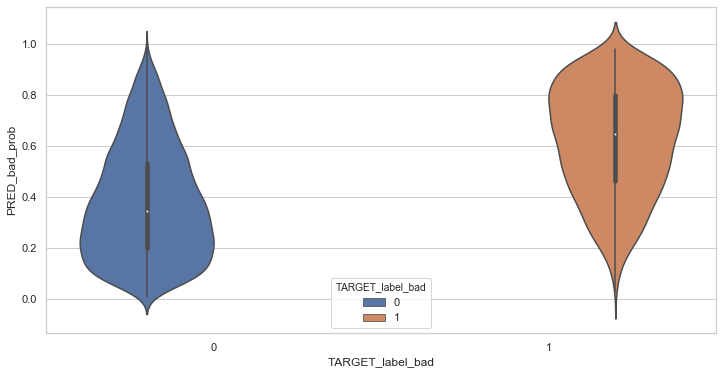

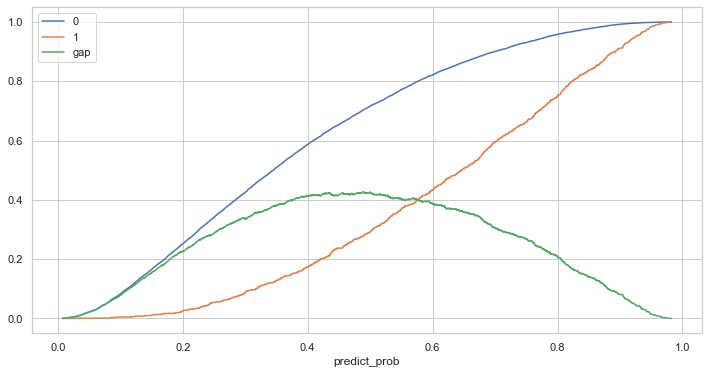

                     0         1       gap
predict_prob                              
0.488646      0.702516  0.276091  0.426425


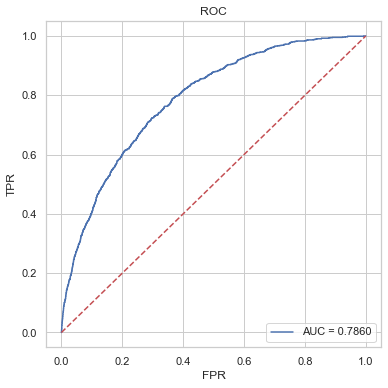

auc: 0.7859854644505088
gini: 0.5719709289010175


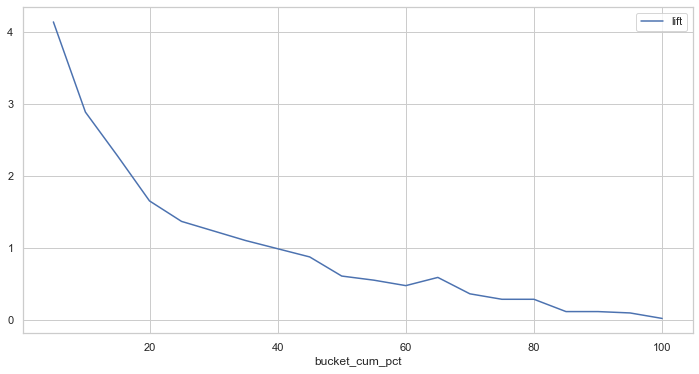

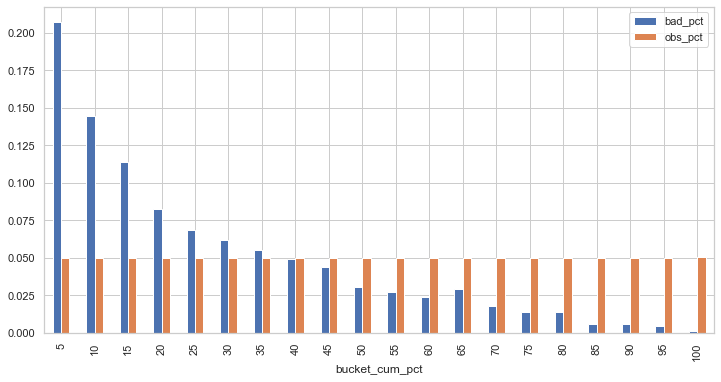

In [417]:
X, y = X_train_0.values, y_train_0.values
# X, y = X_test.values, y_test.values
# X, y = _df_features_oot.values, _df_labels_oot.values
# y_pred = model.predict(x=X)
# y_pred = model.predict_proba(X=X)

X = pd.DataFrame(X, columns=X_train.columns)[model_cols].values
X = np.concatenate([np.array([[1]]*X.shape[0]), X], axis=1)
y_pred = logistic_model_res.predict(exog=X)
y_pred = np.concatenate([(1-y_pred).reshape([-1, 1]), y_pred.reshape([-1, 1])], axis=1)

############################################################
ks, crossdens = func_calc_ks_cross(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print(ks)

auc = func_calc_auc_roc(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print("auc: {}".format(auc))
print("gini: {}".format(2*auc-1))

lift_table = func_calc_lift(
    y_labels=pd.Series(y[:, 1]).apply(lambda s0: ("good" if s0==0 else "bad")),
    y_pred=y_pred[:, -1],
    bucket_cnt=20, bad_label="bad", plot=True
)
# print(lift_table)

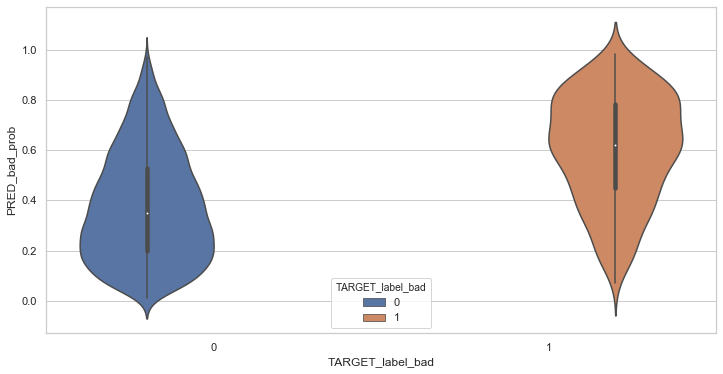

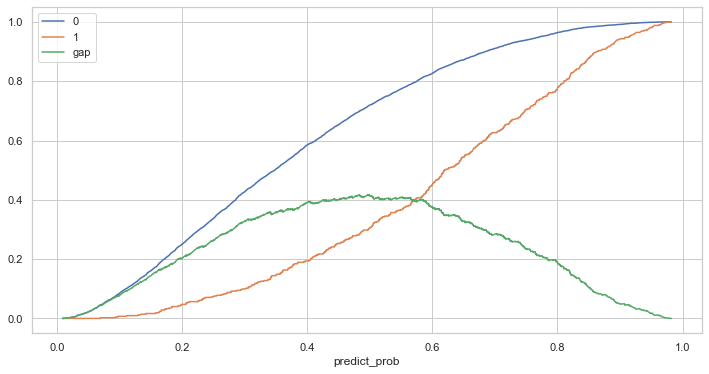

                     0         1       gap
predict_prob                              
0.49703       0.716009  0.297872  0.418136


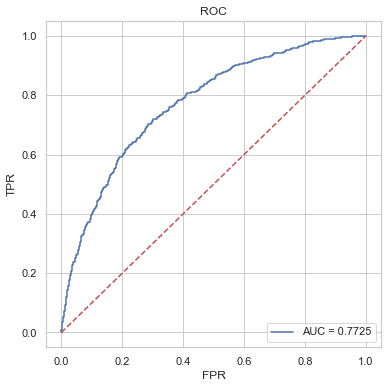

auc: 0.772493364024719
gini: 0.544986728049438


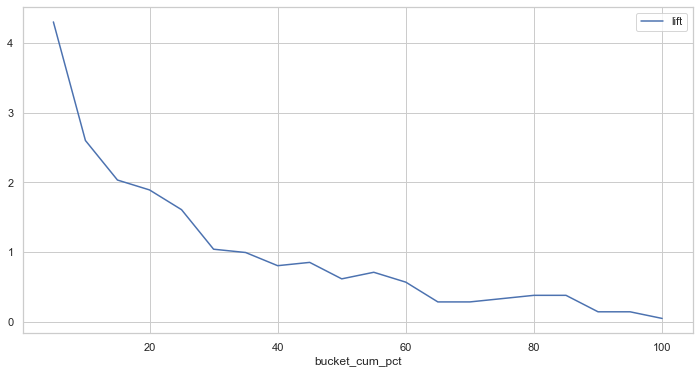

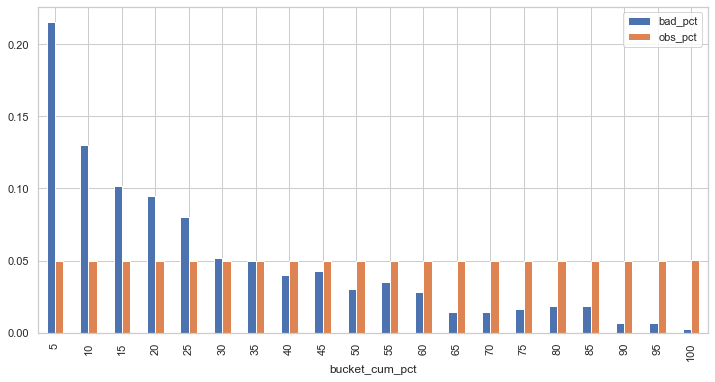

In [418]:
# X, y = X_train_0.values, y_train_0.values
X, y = X_test.values, y_test.values
# X, y = _df_features_oot.values, _df_labels_oot.values
# y_pred = model.predict(x=X)
# y_pred = model.predict_proba(X=X)

X = pd.DataFrame(X, columns=X_train.columns)[model_cols].values
X = np.concatenate([np.array([[1]]*X.shape[0]), X], axis=1)
y_pred = logistic_model_res.predict(exog=X)
y_pred = np.concatenate([(1-y_pred).reshape([-1, 1]), y_pred.reshape([-1, 1])], axis=1)

############################################################
ks, crossdens = func_calc_ks_cross(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print(ks)

auc = func_calc_auc_roc(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print("auc: {}".format(auc))
print("gini: {}".format(2*auc-1))

lift_table = func_calc_lift(
    y_labels=pd.Series(y[:, 1]).apply(lambda s0: ("good" if s0==0 else "bad")),
    y_pred=y_pred[:, -1],
    bucket_cnt=20, bad_label="bad", plot=True
)
# print(lift_table)

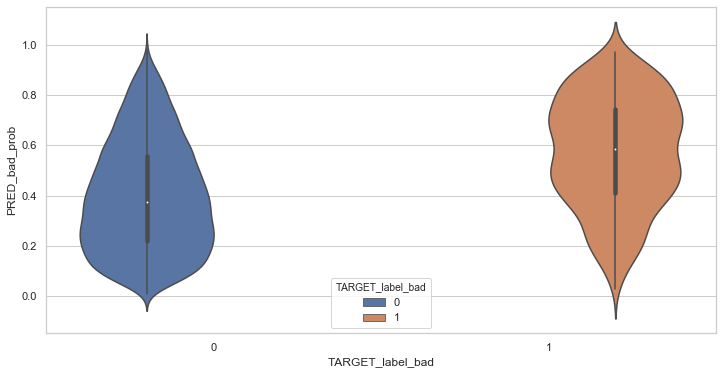

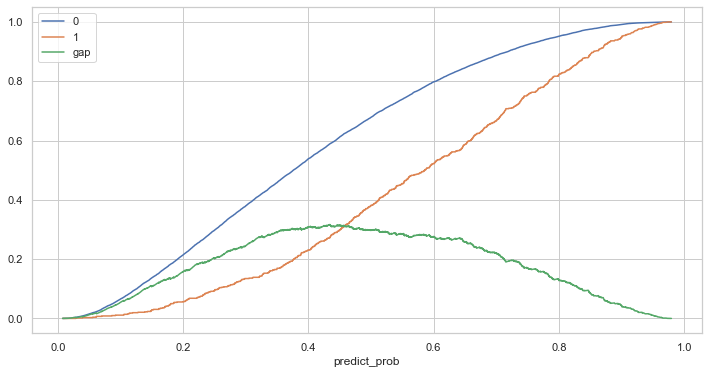

                     0         1      gap
predict_prob                             
0.434247      0.588635  0.271845  0.31679


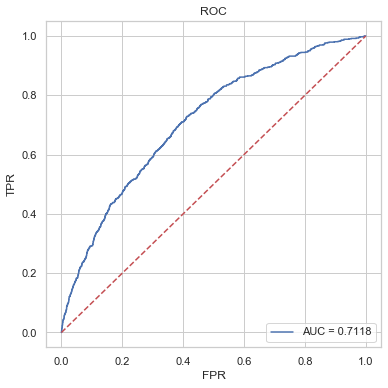

auc: 0.711797720214514
gini: 0.4235954404290281


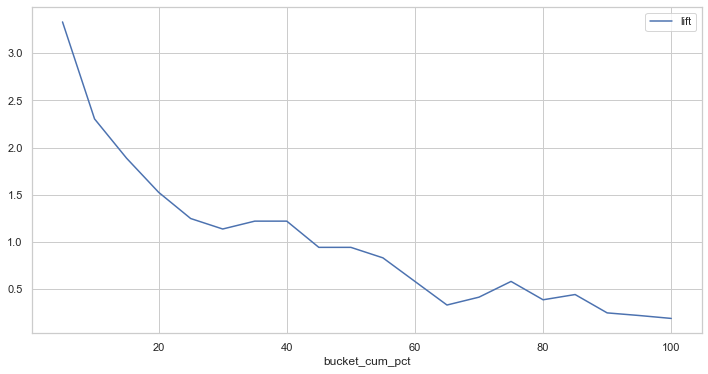

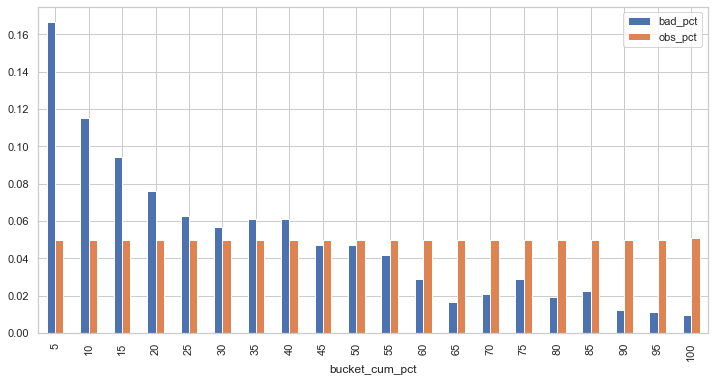

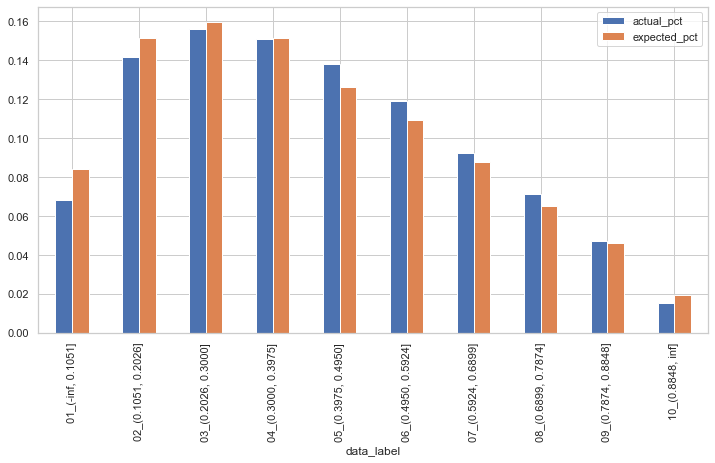

0.007557748972328827


In [419]:
# X, y = X_train_0.values, y_train_0.values
# X, y = X_test.values, y_test.values
X, y = _df_features_oot.values, _df_labels_oot.values
# y_pred = model.predict(x=X)
# y_pred = model.predict_proba(X=X)

X = pd.DataFrame(X, columns=X_train.columns)[model_cols].values
X = np.concatenate([np.array([[1]]*X.shape[0]), X], axis=1)
y_pred = logistic_model_res.predict(exog=X)
y_pred = np.concatenate([(1-y_pred).reshape([-1, 1]), y_pred.reshape([-1, 1])], axis=1)

############################################################
ks, crossdens = func_calc_ks_cross(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print(ks)

auc = func_calc_auc_roc(y_labels=y[:, -1], y_pred=y_pred[:, -1], plot=True)
print("auc: {}".format(auc))
print("gini: {}".format(2*auc-1))

lift_table = func_calc_lift(
    y_labels=pd.Series(y[:, 1]).apply(lambda s0: ("good" if s0==0 else "bad")),
    y_pred=y_pred[:, -1],
    bucket_cnt=20, bad_label="bad", plot=True
)
# print(lift_table)


X, y = _df_features.values, _df_labels.values[:, 1]
X = pd.DataFrame(X, columns=X_train.columns)[model_cols].values
X = np.concatenate([np.array([[1]]*X.shape[0]), X], axis=1)
y_pred_training_dev = logistic_model_res.predict(exog=X)

X, y = _df_features_oot.values, _df_labels_oot.values[:, 1]
X = pd.DataFrame(X, columns=X_train.columns)[model_cols].values
X = np.concatenate([np.array([[1]]*X.shape[0]), X], axis=1)
y_pred_oot = logistic_model_res.predict(exog=X)

psi, psi_table = func_calc_psi_continuous_v1(in_data_actual=y_pred_oot, in_data_expected=y_pred_training_dev, plot=True)
print(psi)
# psi_table

In [386]:
# df_features_psi_summary = func_calc_psi_discrete_features_monthly(
#     in_data_features = df_train_master_cvt[model_cols],
#     in_data_YM = df_train_master_cvt["ListingInfo_YM"],
#     base_last_months=4,
#     verbose=1,
# #     verbose=0,
# )
# df_features_psi_summary.to_clipboard()
# df_features_psi_summary

In [ ]:
# crosstab_converted = func_woe_report_v1(
#     in_var=func_binning_continuous_v2(
#         in_df=df_train_master, var_name="SocialNetwork_6",
#         bins=[-np.inf, 0, 1, np.inf], fillna_value=-9999, right_border=True, reverse_label=True,
#     ), in_target=df_train_master["target_label"], with_total=True,
# )
# crosstab_converted

In [44]:
# data_converted, crosstab_converted, mapping_gb_class = func_auto_combining_discrete_v1(
#     in_var=df_train_master["UserInfo_20"], in_target=df_train_master["target_label"],
#     min_pct=0.05, max_bins_cnt=5, method="01_equal_width",
# )
# crosstab_converted

In [45]:
# data_converted, crosstab_converted, mapping_gb_class = func_auto_combining_discrete_v1(
#     in_var=df_train_master["UserInfo_20"], in_target=df_train_master["target_label"],
#     min_pct=0.05, max_bins_cnt=5, method="02_best_ks",
# )
# crosstab_converted

In [46]:
# data_converted, crosstab_converted, boundary = func_auto_binning_continuous_v2(
#     in_df=df_train_master, var_name="SocialNetwork_5", target_label="target_label",
#     min_pct=0.05, max_bins_cnt=10, fillna_value=-9999, method="01_decision_tree",
# )
# crosstab_converted

In [47]:
# data_converted, crosstab_converted, boundary = func_auto_binning_continuous_v2(
#     in_df=df_train_master, var_name="SocialNetwork_5", target_label="target_label",
#     min_pct=0.05, max_bins_cnt=10, fillna_value=-9999, method="02_best_ks",
# )
# crosstab_converted

In [3]:
columns_info_credit = OrderedDict({
    "id": {
        "dtype": str,
        "mapping": None,
    },
    "name": {
        "dtype": str,
        "mapping": None,
    },
    "cert_type": {
        "dtype": str,
        "mapping": {
            "0": "身份证",
            "1": "户口簿",
            "2": "护照",
            "3": "军官证",
            "4": "士兵证",
            "5": "港澳居民来往内地通行证",
            "6": "台湾同胞来往内地通行证",
            "7": "临时身份证",
            "8": "外国人居留证",
            "9": "警官证",
            "A": "香港身份证",
            "B": "澳门身份证",
            "X": "其他证件",
        },
    },
    "cert_no": {
        "dtype": str,
        "mapping": None,
    },
    "org_code": {
        "dtype": str,
        "mapping": {
            "30110105201601002": "北京捷越联合信息资讯有限公司",
            "99110105201512001": "乐融多源（北京）科技有限公司",
            "30310115201601002": "上海证大投资咨询有限公司",
        },
    },
    "create_time": {
        "dtype": str,
        "mapping": None,
    },
    "account": {
        "dtype": str,
        "mapping": None,
    },
    "date_opened": {
        "dtype": str,
        "mapping": None,
    },
    "date_closed": {
        "dtype": str,
        "mapping": None,
    },
    "credit_limit": {
        "dtype": float,
        "mapping": None,
    },
    "guarantee_way": {
        "dtype": str,
        "mapping": {
            "1": "质押（含保证金）",
            "2": "抵押",
            "3": "自然人保证",
            "4": "信用/免担保",
            "5": "组合（含自然人保证）",
            "6": "组合（不含自然人保证）",
            "7": "农户联保",
            "9": "其他",
        },
    },
    "credit_type": {
        "dtype": str,
        "mapping": {
            "1": "信用贷款-现金贷（大于30天）",
            "2": "循环贷款业务",
            "3": "融资租赁业务",
            "5": "房产抵押贷款",
            "6": "车辆抵押贷款",
            "7": "信用贷款-短期现金贷（<=30天）",
            "8": "信用贷款-消费分期贷（有业务场景）",
            "Z": "其他业务",
        },
    },
    "purpose": {
        "dtype": str,
        "mapping": {
            "01": "经营性",
            "02": "消费性",
            "03": "无指定用途",
            "05": "车贷",
            "06": "房贷",
            "99": "其他",
        },
    },
    "repay_freq": {
        "dtype": str,
        "mapping": {
            "01": "日",
            "02": "周",
            "03": "月",
            "04": "季",
            "05": "半年",
            "06": "年",
            "07": "一次性",
            "08": "不定期",
            "99": "其他",
        },
    },
    "payment_type": {
        "dtype": str,
        "mapping": {
            "1": "等额本息还款法",
            "2": "等额本金还款法",
            "3": "按月还息到期还本",
            "4": "一次性还清",
            "5": "按比例分期还款法",
            "9": "其他",
        },
    },
    "cycle": {
        "dtype": str,
        "mapping": {
            "0": "否",
            "1": "是",
        },
    },
    
    "apply_no": {
        "dtype": str,
        "mapping": None,
    },
    "apply_sum": {
        "dtype": float,
        "mapping": None,
    },
    "gender": {
        "dtype": str,
        "mapping": {
            "0": "未知的性别",
            "1": "男",
            "2": "女",
            "9": "未说明性别",
        },
    },
    "marriage": {
        "dtype": str,
        "mapping": {
            "10": "未婚",
            "20": "已婚",
            "30": "丧偶",
            "40": "离婚",
            "90": "未说明婚姻状况",
        },
    },
    "edu_level": {
        "dtype": str,
        "mapping": {
            "10": "研究生及以上",
            "20": "大学本科",
            "30": "大学专科和专科学校",
            "40": "中等专业学校或中等技术学校",
            "50": "技术学校",
            "60": "高中",
            "70": "初中",
            "80": "小学",
            "90": "文盲或半文盲",
            "99": "未知",
        },
    },
    "mobile_tel": {
        "dtype": str,
        "mapping": None,
    },
    "contact_address": {
        "dtype": str,
        "mapping": None,
    },
    "address": {
        "dtype": str,
        "mapping": None,
    },
    "condition": {
        "dtype": str,
        "mapping": {
            "1": "自置（自建，自购）无贷款或贷款已还清",
            "2": "按揭",
            "3": "与亲属同住",
            "4": "集体宿舍",
            "5": "租房",
            "6": "共有住宅",
            "7": "其他",
            "9": "未知",
        },
    },
    "estatus": {
        "dtype": str,
        "mapping": {
            "0": "非自雇在职人员",
            "1": "自雇",
            "2": "失业",
            "Z": "未知",
        },
    },
    "company": {
        "dtype": str,
        "mapping": None,
    },
    "company_address": {
        "dtype": str,
        "mapping": None,
    },
    "position": {
        "dtype": str,
        "mapping": {
            "1": "高级领导",
            "2": "中级领导",
            "3": "一般员工",
            "4": "其他",
            "9": "未知",
        },
    },
    "annual_income": {
        "dtype": float,
        "mapping": None,
    },
    "first_contract_name": {
        "dtype": str,
        "mapping": None,
    },
    "first_contract_relation": {
        "dtype": str,
        "mapping": {
            "0": "父子",
            "1": "母子",
            "2": "配偶",
            "3": "子女",
            "4": "其他亲属",
            "5": "同事",
            "6": "朋友",
            "7": "兄弟姐妹",
            "8": "其他",
        },
    },
    "first_contract_tel": {
        "dtype": str,
        "mapping": None,
    },
})

df_credit = pd.read_csv(
    "./data/credit.csv", sep=",", encoding="utf-8", low_memory=False,
    dtype=dict([(k, v["dtype"]) for k, v in columns_info_credit.items()]),
)
df_credit[[k for k, v in columns_info_credit.items() if v["dtype"]==str]] = \
    df_credit[[k for k, v in columns_info_credit.items() if v["dtype"]==str]].fillna("")

In [4]:
df_repay_summary = pd.read_csv(
    "./data/repay_summary.csv", sep=",", encoding="utf-8", low_memory=False,
    dtype={
       "account": str,
       "org_code": str,
       "sum_actual_pay_amount": float,
       "min_period_number": float,
       "max_period_number": float,
       "cnt_period_number": float,
       "min_billing_date": str,
       "max_billing_date": str,
})

In [5]:
columns_info_credit_repay = OrderedDict({
    "account": {
        "dtype": str,
        "mapping": None,
    },
    "account_status": {
        "dtype": str,
        "mapping": {
            "0": "正常未结清",
            "1": "代偿未结清",
            "2": "正常结清",
            "3": "代偿结清",
            "4": "呆账",
            "5": "核销",
            "6": "以资抵债",
            "7": "提前还款未结清",
            "8": "提前还款结清",
        },
    },
    "actual_pay_amount": {
        "dtype": float,
        "mapping": None,
    },
    "actual_pay_date": {
        "dtype": str,
        "mapping": None,
    },
    "balance": {
        "dtype": float,
        "mapping": None,
    },
    "billing_date": {
        "dtype": str,
        "mapping": None,
    },
    "billing_date_ym": {
        "dtype": str,
        "mapping": None,
    },
    "cnt_period_number": {
        "dtype": float,
        "mapping": None,
    },
    "create_time": {
        "dtype": str,
        "mapping": None,
    },
    "credit_limit": {
        "dtype": float,
        "mapping": None,
    },
    "credit_type": {
        "dtype": str,
        "mapping": {
            "1": "信用贷款-现金贷（大于30天）",
            "2": "循环贷款业务",
            "3": "融资租赁业务",
            "5": "房产抵押贷款",
            "6": "车辆抵押贷款",
            "7": "信用贷款-短期现金贷（<=30天）",
            "8": "信用贷款-消费分期贷（有业务场景）",
            "Z": "其他业务",
        },
    },
    "date_closed": {
        "dtype": str,
        "mapping": None,
    },
    "date_opened": {
        "dtype": str,
        "mapping": None,
    },
    "gross_liability": {
        "dtype": float,
        "mapping": None,
    },
    "guarantee_way": {
        "dtype": str,
        "mapping": {
            "1": "质押（含保证金）",
            "2": "抵押",
            "3": "自然人保证",
            "4": "信用/免担保",
            "5": "组合（含自然人保证）",
            "6": "组合（不含自然人保证）",
            "7": "农户联保",
            "9": "其他",
        },
    },
    "id": {
        "dtype": str,
        "mapping": None,
    },
    "max_billing_date": {
        "dtype": str,
        "mapping": None,
    },
    "max_period_number": {
        "dtype": float,
        "mapping": None,
    },
    "min_billing_date": {
        "dtype": str,
        "mapping": None,
    },
    "min_period_number": {
        "dtype": float,
        "mapping": None,
    },
    "org_code": {
        "dtype": str,
        "mapping": {
            "30110105201601002": "北京捷越联合信息资讯有限公司",
            "99110105201512001": "乐融多源（北京）科技有限公司",
            "30310115201601002": "上海证大投资咨询有限公司",
        },
    },
    "period_number": {
        "dtype": float,
        "mapping": None,
    },
    "purpose": {
        "dtype": str,
        "mapping": {
            "01": "经营性",
            "02": "消费性",
            "03": "无指定用途",
            "05": "车贷",
            "06": "房贷",
            "99": "其他",
        },
    },
    "repay_freq": {
        "dtype": str,
        "mapping": {
            "01": "日",
            "02": "周",
            "03": "月",
            "04": "季",
            "05": "半年",
            "06": "年",
            "07": "一次性",
            "08": "不定期",
            "99": "其他",
        },
    },
    "sum_actual_pay_amount": {
        "dtype": str,
        "mapping": None,
    },
})

# _data = []
# _fp_credit_repay = "./data/credit_repay"
# for _fn in os.listdir(_fp_credit_repay)[:]:
#     _df = pd.read_csv(
#         "{}/{}".format(_fp_credit_repay, _fn), sep=",", encoding="utf-8", low_memory=False,
#         dtype=dict([(k, v["dtype"]) for k, v in columns_info_credit_repay.items()]),
#     )
#     _df[[k for k, v in columns_info_credit_repay.items() if v["dtype"]==str]] = _df[[k for k, v in columns_info_credit_repay.items() if v["dtype"]==str]].fillna("")
    
#     _data.append(_df)
    
# df_credit_repay = pd.concat(_data, ignore_index=True)
# df_credit_repay = df_credit_repay.sort_values(by=["org_code", "account", "period_number"], ascending=[True, True, True]).reset_index(drop=True)

##################################################################
# with open("./data/df_credit_repay.pkl", mode="wb") as fw:
#     pickle.dump(file=fw, obj=df_credit_repay)

with open("./data/df_credit_repay.pkl", mode="rb") as fr:
    df_credit_repay = pickle.load(file=fr)
##################################################################

In [6]:
curr_date_string = "2017-12-31"

_df_credit_repay_0 = df_credit_repay \
    .loc[(
        (df_credit_repay["actual_pay_date"].apply(lambda s0: s0[:10])<=curr_date_string) &
        (df_credit_repay["max_billing_date"].apply(lambda s0: s0[:10])<=curr_date_string)
        ),
    ["account", "org_code", "period_number", "cnt_period_number",
     "actual_pay_amount", "actual_pay_date", "billing_date", "credit_limit",
     "date_opened", "date_closed", "max_billing_date",
    ]
].reset_index(drop=True)

_df_credit_repay_0 = _df_credit_repay_0 \
    .query("cnt_period_number>=12 & cnt_period_number<=36") \
    .reset_index(drop=True)

_date_columns = ["actual_pay_date", "billing_date", "date_opened", "date_closed", "max_billing_date"]
_df_credit_repay_0[_date_columns] = _df_credit_repay_0[_date_columns].applymap(lambda s0: (s0[0:10] if s0!="" else ""))


#########################################################################################################
_df_account_curr_status = _df_credit_repay_0[["account", "org_code", "cnt_period_number", "max_billing_date", "date_opened", "date_closed"]].drop_duplicates() \
    .query("max_billing_date==date_closed")
_df_account_curr_status["account_status"] = "closed_ontime"

_tmp = _df_credit_repay_0[["account", "org_code", "cnt_period_number", "max_billing_date", "date_opened", "date_closed"]].drop_duplicates() \
    .query("max_billing_date!=date_closed") \
    .query("max_billing_date=='{}'".format(curr_date_string))
_tmp["account_status"] = "opened"

_df_account_curr_status = _df_account_curr_status.append(_tmp, ignore_index=True).reset_index(drop=True)


#########################################################################################################
_df_credit_repay_0 = _df_account_curr_status[["account", "org_code"]].merge(
    right=_df_credit_repay_0,
    how="left", on=["account", "org_code"],
).reset_index(drop=True)

_df_credit_repay_0[["period_number", "cnt_period_number"]] = _df_credit_repay_0[["period_number", "cnt_period_number"]].applymap(int)


#########################################################################################################
_df_credit_repay_0["date_opened_QTR"] = _df_credit_repay_0["date_opened"].apply(lambda s0: "{}Q{:02}".format(s0[0:4], (int(s0[5:7])-1)//3+1))
_df_credit_repay_0["cnt_period_number_upto"] = _df_credit_repay_0["cnt_period_number"].apply(lambda s0: ((s0-1)//12+1)*12)


In [7]:
def calculate_diff_days(billing_date, actual_pay_date, date_closed, curr_date_string):
    if actual_pay_date=="":
        # actual_pay_date = min(date_closed, curr_date_string)
        actual_pay_date = "2099-01-01"
    d = (datetime.datetime.strptime(actual_pay_date, "%Y-%m-%d") - datetime.datetime.strptime(billing_date, "%Y-%m-%d")).days
    return d

def calculate_diff_months(billing_date, actual_pay_date, date_closed, curr_date_string):
    if actual_pay_date=="":
        # actual_pay_date = min(date_closed, curr_date_string)
        actual_pay_date = "2099-01-01"
    
    _actual_pay_date = datetime.datetime.strptime(actual_pay_date, "%Y-%m-%d")
    _billing_date = datetime.datetime.strptime(billing_date, "%Y-%m-%d")
    diff_months = 12*(_actual_pay_date.year - _billing_date.year) + (_actual_pay_date.month - _billing_date.month)
    
    return diff_months

def calculate_delq_m(months, days):
#     if days<=0:
#         delq_m = 0
#     elif days<=30:
#         delq_m = 1
#     elif days<=60:
#         delq_m = 2
#     elif days<=90:
#         delq_m = 3
#     elif days<=120:
#         delq_m = 4
#     elif days<=150:
#         delq_m = 5
#     elif days<=180:
#         delq_m = 6
#     else:
#         delq_m = 7
    
    if months<0:
        delq_m = 0
    elif months==1:
        delq_m = (1 if days>0 else 0)
    elif months>=7:
        delq_m = 7
    else:
        delq_m = months
    
    return delq_m


def func_wrap(in_df):
    df = in_df.reset_index(drop=True)
    
    df["diff_days"] = df.apply(lambda s0: calculate_diff_days(s0["billing_date"], s0["actual_pay_date"], s0["date_closed"], curr_date_string), axis=1)
    df["diff_months"] = df.apply(lambda s0: calculate_diff_months(s0["billing_date"], s0["actual_pay_date"], s0["date_closed"], curr_date_string), axis=1)
    df["delq_m"] = df.apply(lambda s0: calculate_delq_m(s0["diff_months"], s0["diff_days"]), axis=1)
    df["overdue"] = df["delq_m"].apply(lambda s0: (0 if s0==0 else 1))
    
    out_df = df
    return out_df

data_size = _df_credit_repay_0.shape[0]
block_cnt = 1000
block_size = data_size//(block_cnt-1)

_df_splited = [
    _df_credit_repay_0[block_size*s0:min(block_size*(s0+1), data_size)]
    for s0 in range(block_cnt)]

cpu_cnt = 16
pool = multiprocessing.Pool(processes=cpu_cnt)

res = [pool.apply_async(func=func_wrap, args=(s0,)) for s0 in _df_splited[:]]
pool.close()
pool.join()

res = [s0.get() for s0 in res]
_df_credit_repay_1 = pd.concat(res, ignore_index=True).sort_values(by=["org_code", "account", "period_number"], ascending=[True, True, True]).reset_index(drop=True)

In [8]:
def _calc_overdue_cum(in_df):
    df = in_df.reset_index(drop=True)
    
    _overdue = df["overdue"].tolist()
    _cumsum = 0
    _overdue_cum = []
    for s0 in _overdue:
        if s0==0:
            _overdue_cum.append(0)
            _cumsum = 0
        else:
            _cumsum = _cumsum+1
            # _cumsum = min(_cumsum, 7)
            _overdue_cum.append(_cumsum)
    df["overdue_cum_0"] = _overdue_cum
    df["overdue_cum"] = df["overdue_cum_0"].apply(lambda s0: min(s0, 7))
    df["overdue_cum_lead1"] = df["overdue_cum"].shift(periods=-1)
    
    out_df = df
    return out_df

def _calc_overdue_maxhist(in_df):
    df = in_df.reset_index(drop=True)
    
    overdue = df["overdue"].tolist()
    overdue_cum = df["overdue_cum"].tolist()
    overdue_maxhist = []
    
    _last_overdue = 0
    _max_hist_overdue = 0
    for _idx, (_curr_overdue, _curr_overdue_cum) in enumerate(zip(overdue, overdue_cum)):
        _curr_overdue_cum = int(_curr_overdue_cum)
        
        if _curr_overdue==1 and _last_overdue==0:
            _max_hist_overdue = max(_max_hist_overdue, 1)
        elif _curr_overdue==1 and _last_overdue==1:
            if _max_hist_overdue<_curr_overdue_cum:
                _max_hist_overdue = max(_curr_overdue_cum, _max_hist_overdue)
            else:
                _max_hist_overdue = max(min(_curr_overdue_cum, _max_hist_overdue+1), _max_hist_overdue)

        # print("{:02d}".format(_idx), _curr_overdue, _last_overdue, _curr_overdue_cum, _max_hist_overdue)
        _last_overdue = _curr_overdue
        
        overdue_maxhist.append(_max_hist_overdue)
    
    df["overdue_maxhist"] = overdue_maxhist
    
    out_df = df
    return out_df

def func_wrap(in_df):
    df = in_df.reset_index(drop=True)
    
    df = pd.concat(
        [
            _calc_overdue_maxhist(
                _calc_overdue_cum(_df)
            )
            for _gb, _df in df.groupby(by=["account", "org_code"])
        ],
        ignore_index=True
    )
    
    out_df = df
    return out_df

_df_account = _df_credit_repay_1.reset_index().groupby(by=["org_code", "account"])["index"].apply(lambda s0: s0.tolist()).reset_index()
_account_size = _df_account.shape[0]
block_cnt = 200
block_size = _account_size//block_cnt

_df_splited = []
for _idx in [s0 for s0 in range(block_cnt)][:]:
    _tmp = _df_account[block_size*_idx:block_size*(_idx+1)]
    _tmp_cr = _df_credit_repay_1.iloc[np.concatenate(_tmp["index"].tolist()), :]
    _df_splited.append(_tmp_cr)
_df_splited.append(_df_credit_repay_1.iloc[np.concatenate(_df_account[block_size*block_cnt:_account_size]["index"].tolist()), :])


cpu_cnt = 16
pool = multiprocessing.Pool(processes=cpu_cnt)

res = [pool.apply_async(func=func_wrap, args=(s0,)) for s0 in _df_splited[:]]
pool.close()
pool.join()

res = [s0.get() for s0 in res]
_df_credit_repay_2 = pd.concat(res, ignore_index=True).sort_values(by=["org_code", "account", "period_number"], ascending=[True, True, True]).reset_index(drop=True)

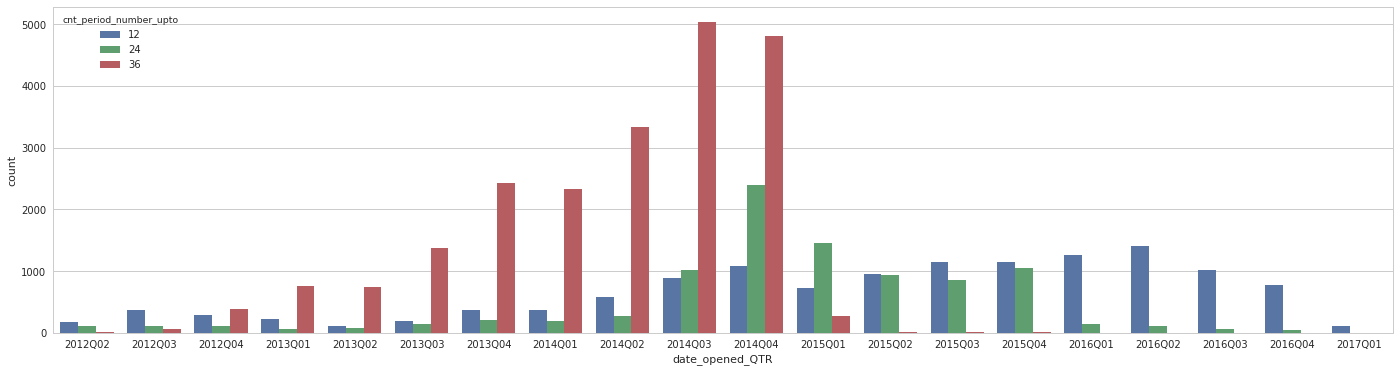

In [9]:
_tmp = _df_credit_repay_2 \
    [["account", "org_code", "cnt_period_number", "cnt_period_number_upto", "date_opened", "date_opened_QTR"]].drop_duplicates()

##################################################################
plt.style.use({"figure.figsize": [s0*3 for s0 in (8, 2)]})
sns.set(style="whitegrid", rc={"figure.figsize": [s0*3 for s0 in (8, 2)]})
##################################################################

sns.barplot(
    data=_tmp.reset_index().groupby(by=["date_opened_QTR", "cnt_period_number", "cnt_period_number_upto"])["index"].count().reset_index().rename(columns={"index": "count"}),
    x="date_opened_QTR", y="count", orient="vertical", ci=0,
    hue="cnt_period_number_upto",
)

##################################################################
plt.style.use({"figure.figsize": [s0*3 for s0 in (4, 2)]})
sns.set(style="whitegrid", rc={"figure.figsize": [s0*3 for s0 in (4, 2)]})
##################################################################

In [10]:
### date_opened>='2013Q04' & date_opened<=2015Q04
df_appsc_model_account = _df_credit_repay_2 \
    .query("date_opened_QTR>='2013Q04' & date_opened_QTR<='2015Q04'") \
    [["account", "org_code"]].drop_duplicates().reset_index(drop=True)

# df_appsc_model_credit
df_appsc_model_credit = df_appsc_model_account.merge(
    right=df_credit,
    how="left", on=["account", "org_code"],
).reset_index(drop=True)

# df_appsc_model_credit_repay
df_appsc_model_credit_repay = df_appsc_model_account.merge(
    right=_df_credit_repay_2,
    how="left", on=["account", "org_code"],
).reset_index(drop=True)

df_appsc_model_credit_repay["billing_date_YM"] = df_appsc_model_credit_repay["billing_date"].apply(lambda s0: s0[:7])
df_appsc_model_credit_repay["billing_date_QTR"] = df_appsc_model_credit_repay["billing_date"].apply(lambda s0: "{}Q{:02}".format(s0[0:4], (int(s0[5:7])-1)//3+1))

In [11]:
# _tmp_df_appsc_model = [df_appsc_model_account, df_appsc_model_credit, df_appsc_model_credit_repay]
# with open("./_tmp_df_appsc_model.pkl", mode="wb") as fw:
#     pickle.dump(obj=_tmp_df_appsc_model, file=fw)

# with open("./_tmp_df_appsc_model.pkl", mode="rb") as fr:
#     df_appsc_model_account, df_appsc_model_credit, df_appsc_model_credit_repay = pickle.load(file=fr)

In [12]:
_tmp = df_appsc_model_credit_repay \
    .reset_index().groupby(by=["billing_date_YM", "overdue_cum_0"])["index"].count().reset_index().rename(columns={"index": "count"})
_tmp["overdue_cum_0"] = _tmp["overdue_cum_0"].apply(lambda s0: "M{:02}".format(s0))


######################################################################################################
_tmp_pivot_0 = _tmp.pivot_table(values="count", index="billing_date_YM", columns="overdue_cum_0").fillna(0.0).applymap(int)
_tmp_pivot = _tmp_pivot_0
_tmp_pivot_0 = _tmp_pivot_0.reset_index()
_tmp_pivot_0.columns.name = ""


######################################################################################################
_tmp_pivot.loc[:, ["M{:02}".format(s0) for s0 in range(1, _tmp_pivot.shape[1])]] = _tmp_pivot.loc[:, ["M{:02}".format(s0) for s0 in range(1, _tmp_pivot.shape[1])]] \
    .T.sort_index(ascending=False).cumsum().sort_index(ascending=True).T

_tmp_pivot = _tmp_pivot[["M{:02}".format(s0) for s0 in range(8)]]
_tmp_pivot.columns = pd.Index([(s0 if s0=="M00" else "{}+".format(s0)) for s0 in _tmp_pivot.columns.tolist()])
_tmp_pivot = _tmp_pivot.reset_index()
_tmp_pivot.columns.name = ""

_tmp_pivot = _tmp_pivot.merge(
    right=_tmp.groupby(by=["billing_date_YM"])["count"].sum().reset_index().rename(columns={"count": "total"}),
    how="left", on=["billing_date_YM"],
)

_tmp_pivot["M00_pct"] = _tmp_pivot["M00"]/_tmp_pivot["total"]
_tmp_pivot[["M{:02}+_pct".format(t) for t in range(1, 8)]] = _tmp_pivot.apply(lambda s0: s0[["M{:02}+".format(t) for t in range(1, 8)]]/s0["total"], axis=1)


######################################################################################################
_tmp_pivot = _tmp_pivot.merge(
    right=_tmp_pivot_0[["billing_date_YM"]+["M{:02}".format(t) for t in range(1, 8)]],
    how="left", on=["billing_date_YM"],
)
_tmp_pivot[["M{:02}_pct".format(t) for t in range(1, 8)]] = _tmp_pivot.apply(lambda s0: s0[["M{:02}".format(t) for t in range(1, 8)]]/s0["total"], axis=1)

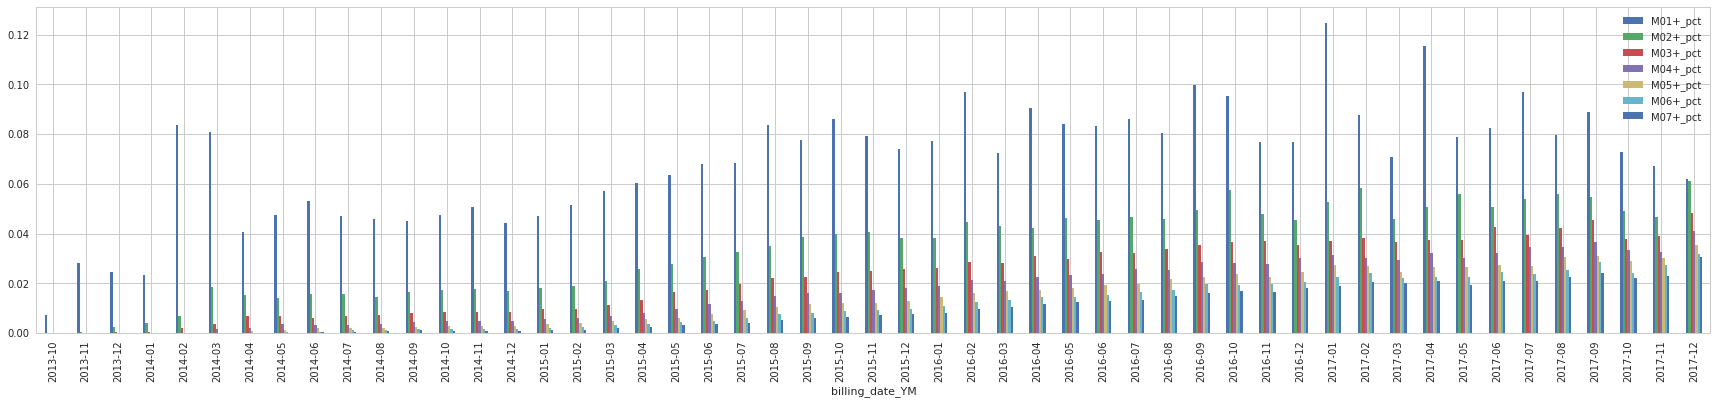

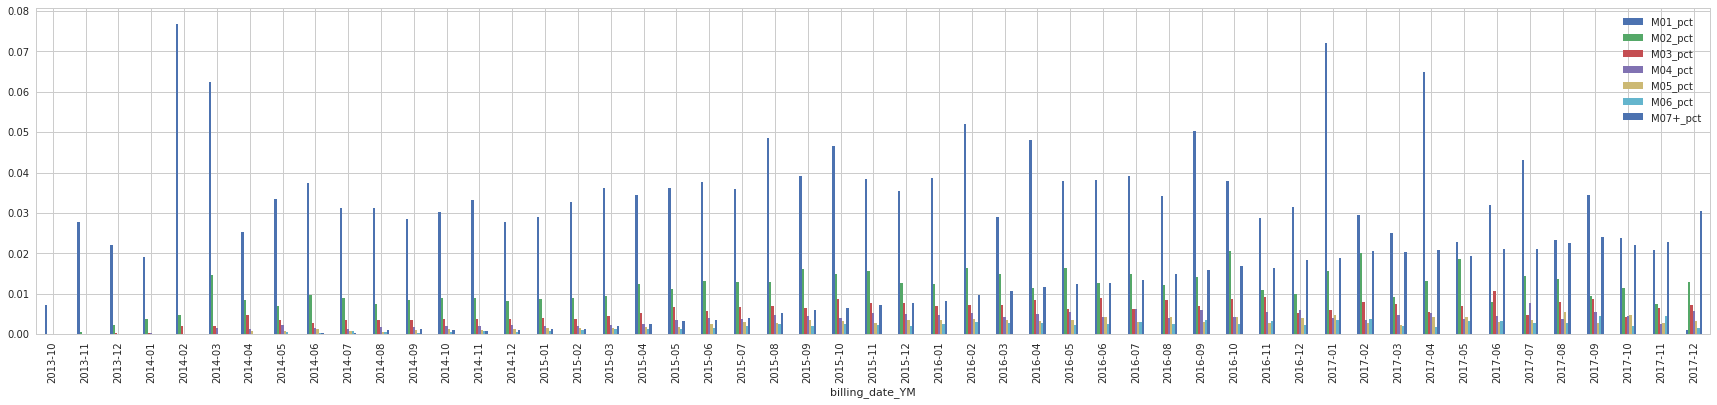

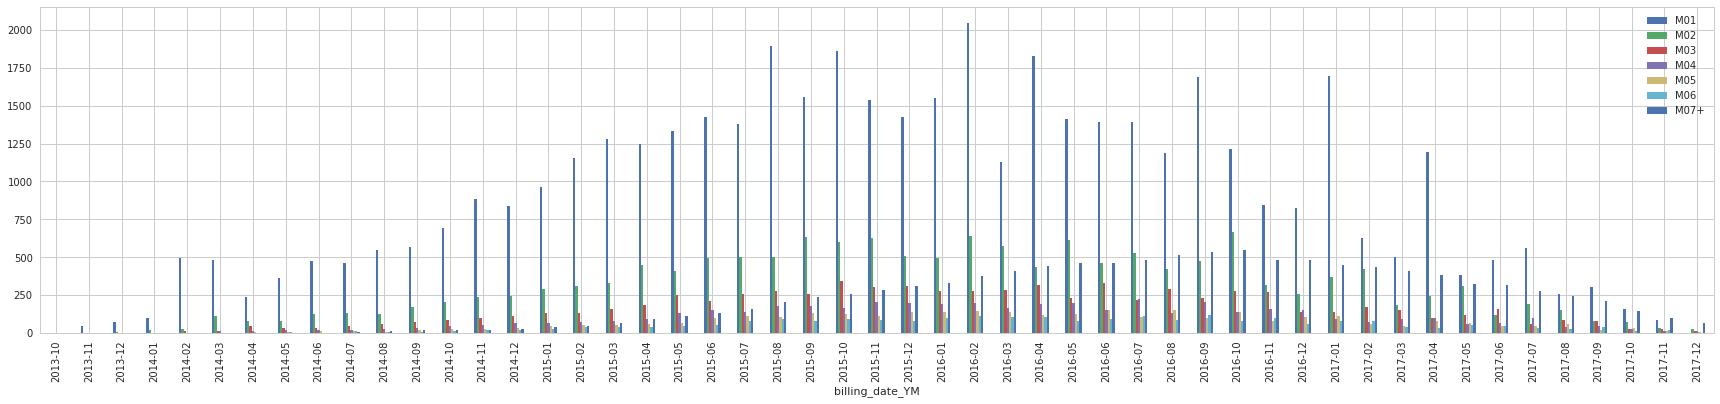

In [13]:
##################################################################
plt.style.use({"figure.figsize": [s0*3 for s0 in (10, 2)]})
sns.set(style="whitegrid", rc={"figure.figsize": [s0*3 for s0 in (10, 2)]})
##################################################################

_tmp_pivot[["billing_date_YM"]+["M{:02}+_pct".format(t) for t in range(1, 8)]].plot(x="billing_date_YM", kind="bar")

_tmp_pivot[["billing_date_YM"]+["M{:02}_pct".format(t) for t in range(1, 7)]+["M07+_pct"]].plot(x="billing_date_YM", kind="bar")
_tmp_pivot[["billing_date_YM"]+["M{:02}".format(t) for t in range(1, 7)]+["M07+"]].plot(x="billing_date_YM", kind="bar")


##################################################################
plt.style.use({"figure.figsize": [s0*3 for s0 in (4, 2)]})
sns.set(style="whitegrid", rc={"figure.figsize": [s0*3 for s0 in (4, 2)]})
##################################################################

In [14]:
####################################################################################################
_summary_rollup = df_appsc_model_credit_repay[df_appsc_model_credit_repay["overdue_cum_lead1"].notna()] \
    [["overdue_cum", "overdue_cum_lead1"]].applymap(lambda s0: ("M7+" if s0==7 else "M{}".format(int(s0)))) \
    .reset_index().groupby(by=["overdue_cum", "overdue_cum_lead1"])["index"].count().reset_index().rename(columns={"index": "count"}) \
    .pivot_table(values="count", index="overdue_cum", columns="overdue_cum_lead1").fillna(0.0).applymap(int)
_summary_rollup["total"] = _summary_rollup.apply(lambda s0: s0.sum(), axis=1)

_summary_rollup.columns.name = "next month"
_summary_rollup.index.name = "this month"
_delq_m = _summary_rollup.shape[0]


####################################################################################################
_summary_rollup_pct = pd.DataFrame(
    (_summary_rollup.drop("total", axis=1).values.T/_summary_rollup.drop("total", axis=1).values.sum(axis=1)).T,
    index=[str(s0) for s0 in range(_delq_m)], columns=[str(s0) for s0 in range(_delq_m)],
)

_summary_rollup_pct.columns = _summary_rollup.drop(labels=["total"], axis=1).columns

_summary_rollup_pct = _summary_rollup_pct.merge(
    right=pd.DataFrame(
        [(sum(_data[:min(_idx+1, 6)]), sum(_data[min(_idx+1, 6):])) for _idx, _data in enumerate(_summary_rollup_pct.values)],
        index=[str(s0) for s0 in range(_delq_m)], columns=["KeepOrRollBack", "RollForward"],
    ), how="left", left_index=True, right_index=True,
)

_summary_rollup_pct.index = _summary_rollup.index


_summary_rollup_pct

,M0,M1,M2,M3,M4,M5,M6,M7+,KeepOrRollBack,RollForward
this month,,,,,,,,,,
M0,0.957882,0.042118,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.957882,0.042118
M1,0.666159,0.000000,0.333841,0.000000,0.000000,0.000000,0.00000,0.000000,0.666159,0.333841
M2,0.490596,0.000000,0.000000,0.509404,0.000000,0.000000,0.00000,0.000000,0.490596,0.509404
M3,0.364923,0.000000,0.000000,0.000000,0.635077,0.000000,0.00000,0.000000,0.364923,0.635077
M4,0.289523,0.000000,0.000000,0.000000,0.000000,0.710477,0.00000,0.000000,0.289523,0.710477
M5,0.248120,0.000000,0.000000,0.000000,0.000000,0.000000,0.75188,0.000000,0.248120,0.751880
M6,0.219133,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.780867,0.219133,0.780867
M7+,0.149112,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.850888,0.149112,0.850888


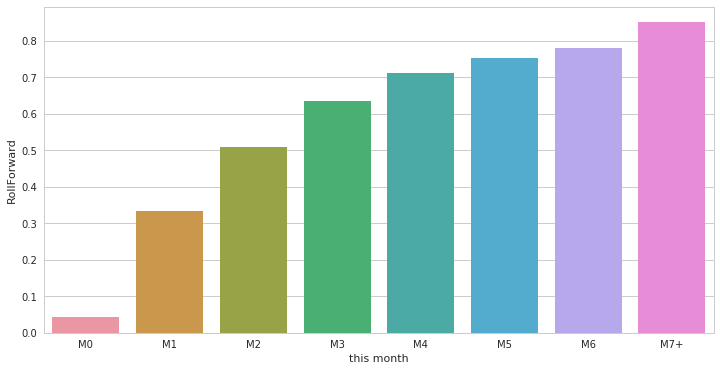

In [15]:
sns.barplot(x=_summary_rollup_pct.index, y=_summary_rollup_pct["RollForward"])

In [16]:
_tmp_vingate = df_appsc_model_credit_repay \
    [["account", "org_code", "date_opened", "date_opened_QTR", "period_number", "billing_date_YM", "cnt_period_number", "cnt_period_number_upto", "overdue_maxhist"]] \
    .groupby(by=["date_opened_QTR", "cnt_period_number_upto", "cnt_period_number", "account", "org_code"]) \
    ["overdue_maxhist"].apply(lambda s0: ",".join([str(s0) for s0 in s0.tolist()])) \
    .reset_index().rename(columns={"overdue_maxhist": "overdue_maxhist_list_0"})

_tmp_vingate["overdue_maxhist_list"] = _tmp_vingate[["cnt_period_number_upto", "overdue_maxhist_list_0"]] \
    .apply(lambda s0: 
        (s0["overdue_maxhist_list_0"]
         if len(s0["overdue_maxhist_list_0"].split(","))==s0["cnt_period_number_upto"] else
         ",".join(s0["overdue_maxhist_list_0"].split(",")+[s0["overdue_maxhist_list_0"].split(",")[-1]]*(s0["cnt_period_number_upto"]-len(s0["overdue_maxhist_list_0"].split(","))))
        ), axis=1)


###############################################################################################
_tmp_vingate_1 = _tmp_vingate.set_index(keys=["date_opened_QTR", "cnt_period_number_upto", "account", "org_code"])["overdue_maxhist_list"] \
    .apply(lambda s0: pd.Series([int(t) for t in s0.split(",")])).reset_index() \
    .melt(
        id_vars=["date_opened_QTR", "cnt_period_number_upto", "account", "org_code"], value_vars=[s0 for s0 in range(36)],
        var_name="period_number",  value_name="overdue_maxhist",
    )

_tmp_vingate_1["period_number"] = _tmp_vingate_1["period_number"]+1
_tmp_vingate_1 = _tmp_vingate_1[_tmp_vingate_1["overdue_maxhist"].notna()] \
    .sort_values(by=["org_code", "account", "period_number"]).reset_index(drop=True)
_tmp_vingate_1["overdue_maxhist"] = _tmp_vingate_1["overdue_maxhist"].astype(int)


#####################################################################################################################
_tmp_vingate_stat = _tmp_vingate_1.reset_index() \
    .groupby(by=["cnt_period_number_upto", "date_opened_QTR", "period_number", "overdue_maxhist"]) \
    ["index"].count().reset_index().rename(columns={"index": "count"}) \
    .merge(
        right=_tmp_vingate_1.reset_index() \
            .groupby(by=["cnt_period_number_upto", "date_opened_QTR", "period_number"]) \
            ["index"].count().reset_index().rename(columns={"index": "total"}),
        how="left", on=["cnt_period_number_upto", "date_opened_QTR", "period_number"],
    )

_tmp_vingate_stat["pct"] = _tmp_vingate_stat["count"]/_tmp_vingate_stat["total"]


#####################################################################################################################
_tmp_vingate_stat_pivot = _tmp_vingate_stat \
    .groupby(by=["cnt_period_number_upto", "date_opened_QTR", "period_number"]) \
    .apply(lambda s0: {
        "total": s0["count"].sum(),
        "m2p": {
            "count": s0.query("overdue_maxhist>=2")["count"].sum(),
            "pct": s0.query("overdue_maxhist>=2")["pct"].sum(),
        },
        "m3p": {
            "count": s0.query("overdue_maxhist>=3")["count"].sum(),
            "pct": s0.query("overdue_maxhist>=3")["pct"].sum(),
        },
        "m4p": {
            "count": s0.query("overdue_maxhist>=4")["count"].sum(),
            "pct": s0.query("overdue_maxhist>=4")["pct"].sum(),
        },
    }).reset_index().rename(columns={0: "summary"}) \
    .pivot_table(
        index=["period_number"], columns=["cnt_period_number_upto", "date_opened_QTR"], values="summary",
        aggfunc=lambda s0: s0.tolist()[0],
    )



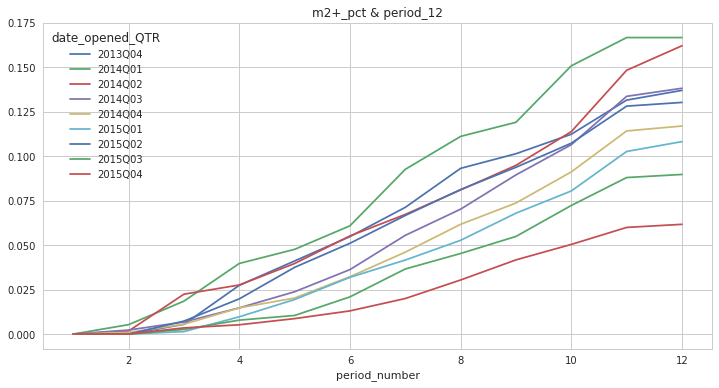

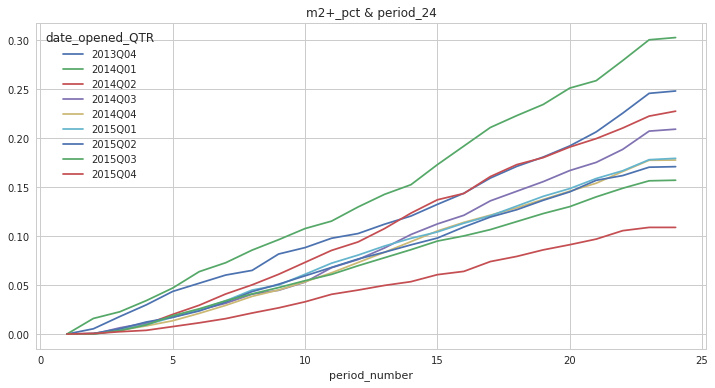

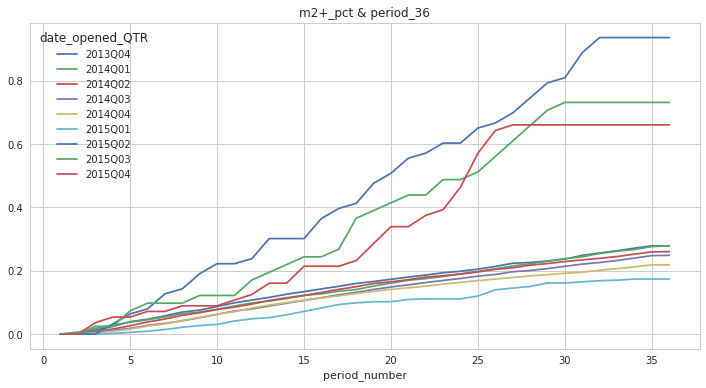

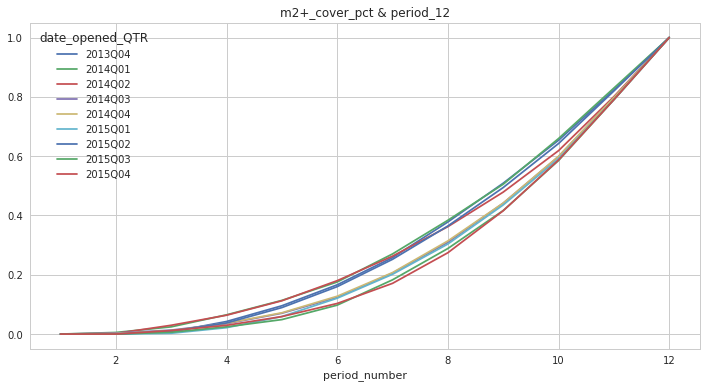

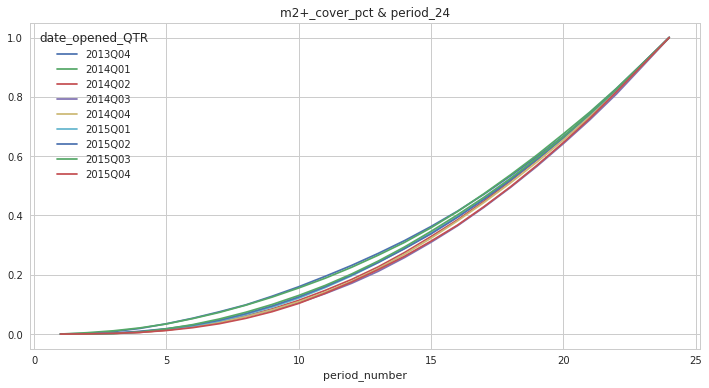

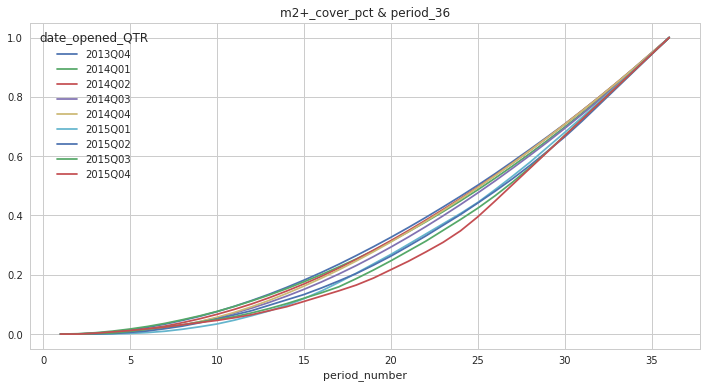

In [17]:
_m = 2

_ = [(
        _tmp_vingate_stat_pivot.T.reset_index().query("cnt_period_number_upto=={}".format(_period)) \
            .set_index(keys=["date_opened_QTR"])[[s0+1 for s0 in range(_period)]].T \
            .applymap(lambda s0: s0["m{}p".format(_m)]["pct"]) \
            .plot(title="m{}+_pct & period_{}".format(_m, _period)),
    )
    for _period in [12, 24, 36]
]

_ = [(
        _tmp_vingate_stat_pivot.T.reset_index().query("cnt_period_number_upto=={}".format(_period)) \
            .set_index(keys=["date_opened_QTR"])[[s0+1 for s0 in range(_period)]].T \
            .applymap(lambda s0: s0["m{}p".format(_m)]["count"]).apply(lambda s0: s0.cumsum()/s0.sum()) \
            .plot(title="m{}+_cover_pct & period_{}".format(_m, _period)),
    )
    for _period in [12, 24, 36]
]

In [18]:
_df_appsc_model_account_overdue_status = df_appsc_model_credit_repay \
    [["account", "org_code", "period_number", "cnt_period_number_upto", "date_opened", "overdue_cum"]] \
    .query("(cnt_period_number_upto==12 & period_number<=10) | (cnt_period_number_upto==24 & period_number<=20) | (cnt_period_number_upto==36 & period_number<=30)") \
    .groupby(by=["account", "org_code", "date_opened", "cnt_period_number_upto"]) \
    ["overdue_cum"].apply(lambda s0: s0.tolist()) \
    .apply(lambda s0: {
        "Mp": max(s0),
        "Mp_cnt": len([t for t in s0 if t==max(s0)]),
    }).reset_index().rename(columns={"overdue_cum": "overdue_status"})

_df_appsc_model_account_overdue_status["date_opened_YM"] = _df_appsc_model_account_overdue_status["date_opened"].apply(lambda s0: s0[:7])


##################################################################################################################
def _func_overdue_status(overdue_status, cnt_period_number_upto):
    if cnt_period_number_upto==12:
        _period = 10
    elif cnt_period_number_upto==24:
        _period = 20
    elif cnt_period_number_upto==36:
        _period = 30
    
    Mp = overdue_status["Mp"]
    Mp_cnt = overdue_status["Mp_cnt"]
    
    if Mp==0:
        rt = "无逾期"
    else:
        rt = "表现期（开户后{}个月）内最大逾期为M{}且次数{}".format(_period, (str(Mp) if Mp!=7 else "{}+".format(Mp)), (">=3" if Mp_cnt>=3 else "={}".format(Mp_cnt)))
    
    return rt
    
_df_appsc_model_account_overdue_status["overdue_status_flag"] = _df_appsc_model_account_overdue_status \
    .apply(lambda s0: _func_overdue_status(s0["overdue_status"], s0["cnt_period_number_upto"]), axis=1)


##################################################################################################################
##################################################################################################################
_df_appsc_model_account_overdue_status_pivot_12 = _df_appsc_model_account_overdue_status \
    .query("cnt_period_number_upto==12") \
    .reset_index().groupby(by=["overdue_status_flag", "date_opened_YM"]) \
    ["index"].count().reset_index().rename(columns={"index": "count"}) \
    .pivot_table(index=["overdue_status_flag"], columns=["date_opened_YM"], values="count") \
    .fillna(0.0).applymap(int)


##################################################################################################################
_df_appsc_model_account_overdue_status_pivot_24 = _df_appsc_model_account_overdue_status \
    .query("cnt_period_number_upto==24") \
    .reset_index().groupby(by=["overdue_status_flag", "date_opened_YM"]) \
    ["index"].count().reset_index().rename(columns={"index": "count"}) \
    .pivot_table(index=["overdue_status_flag"], columns=["date_opened_YM"], values="count") \
    .fillna(0.0).applymap(int)


##################################################################################################################
_df_appsc_model_account_overdue_status_pivot_36 = _df_appsc_model_account_overdue_status \
    .query("cnt_period_number_upto==36") \
    .reset_index().groupby(by=["overdue_status_flag", "date_opened_YM"]) \
    ["index"].count().reset_index().rename(columns={"index": "count"}) \
    .pivot_table(index=["overdue_status_flag"], columns=["date_opened_YM"], values="count") \
    .fillna(0.0).applymap(int)

In [19]:
# _df_appsc_model_account_overdue_status_pivot_12.to_excel("./_df_appsc_model_account_overdue_status_pivot_12.xlsx")
# _df_appsc_model_account_overdue_status_pivot_24.to_excel("./_df_appsc_model_account_overdue_status_pivot_24.xlsx")
# _df_appsc_model_account_overdue_status_pivot_36.to_excel("./_df_appsc_model_account_overdue_status_pivot_36.xlsx")

In [20]:
_df_application = _df_appsc_model_account_overdue_status \
    .query("cnt_period_number_upto==12") \
    .query("date_opened_YM>='2013-11' and date_opened_YM<='2015-12'") \
    .reset_index(drop=True)

_df_application["bad"] = _df_application["overdue_status"].apply(lambda s0: (1 if s0["Mp"]>=2 else 0))
_df_application["good"] = _df_application["overdue_status"].apply(lambda s0: (0 if s0["Mp"]>=2 else 1))

_df_application = _df_application[["account", "org_code", "overdue_status", "bad", "good"]] \
    .merge(
        right=df_appsc_model_credit[[
            "account", "org_code", "date_opened", "date_closed",
            "cert_no", "gender", "marriage", "edu_level", "condition", "estatus",
            "mobile_tel", "address",
            "apply_sum", "credit_limit", "purpose",
        ]],
        how="left", on=["account", "org_code"],
    )

_df_application["TARGET_label"] = _df_application["bad"].apply(lambda s0: ("0_good" if s0==0 else "1_bad"))

In [21]:
import func01_addr_cut.AddrStandard as AS
from func01_addr_cut.AddrStandard import addr_cut
# AS.set_cut_LEV(LEV_flag='L1to4')
AS.set_cut_LEV(LEV_flag='L1to3')

################################################################################
_df_certid_nativecode = pd.read_excel("./func02_phone_area/CERTID_NATIVECODE.xlsx", dtype=np.str).applymap(lambda s0: re.sub("nan", "", s0))
_certid_nativecode = [dict([(_col, _value) for _col, _value in zip(_df_certid_nativecode.columns.values, _line)]) for _line in _df_certid_nativecode.values]

dict_code2name_1to1 = dict(list(set([
    (s0["NATIVE_CODE"][0:2], s0["NATIVE_NAME_1"])
    for s0 in _certid_nativecode
])))
dict_code2name_1to2 = dict(list(set([
    (s0["NATIVE_CODE"][0:4], "/".join([t for t in [s0["NATIVE_NAME_1"], s0["NATIVE_NAME_2"]] if t!=""]))
    for s0 in _certid_nativecode
])))
dict_code2name_1to3 = dict([
    (s0["NATIVE_CODE"], "/".join([t for t in s0["NATIVE"].split("|") if t!=""]))
    for s0 in _certid_nativecode
])

################################################################################
with open("./func02_phone_area/phone_area_mapping.pkl", mode="rb") as fr:
    phone_area_mapping = pickle.load(fr)
    
    phone_area_mapping["phone_mask_prefix"] = phone_area_mapping["phone_mask"].apply(lambda s0: s0[0:7])
    dict_phone_area_mapping = phone_area_mapping[["phone_mask_prefix", "area_stand", "area_stand_code"]] \
        .set_index(keys=["phone_mask_prefix"]) \
        .apply(lambda s0: {
            "area_stand": s0["area_stand"],
            "area_stand_code": s0["area_stand_code"],
        }, axis=1).to_dict()

################################################################################
def _func_area_level(area_name):
    if re.search("北京|上海|广州|深圳", area_name)!=None:
        rt = "1_一线城市"
    elif re.search("成都|重庆|杭州|南京|沈阳|苏州|天津|武汉|西安", area_name)!=None:
        rt = "2_准一线城市"
    elif re.search("长沙|大连|济南|宁波|青岛|无锡|厦门|郑州|长春|常州|哈尔滨|福州|昆明|合肥|东莞|石家庄|呼和浩特|南昌|温州|佛山|贵阳|南宁", area_name)!=None:
        rt = "3_二线城市"
    else:
        rt = "4_其他"
    return rt

#####################################################################################
import difflib
def _string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).quick_ratio()

def _func_addr_similarity(list_address):
    list_address = [s0.replace("/市辖区", "") for s0 in list_address if s0!=""]
    _pair = [(s1, s2, _string_similar(s1, s2)) for (idx_1, s1), (idx_2, s2) in product(list(enumerate(list_address)), list(enumerate(list_address))) if idx_1<idx_2]
    
    rt = (np.mean([s0 for _, _, s0 in _pair]) if len(_pair)>0 else 0.5)
    return rt


################################################################################
_df_application["VAR_cert_area_district"] = _df_application["cert_no"].apply(lambda s0: dict_code2name_1to3.get(s0[0:6], ""))
_df_application["VAR_cert_area_city"] = _df_application["cert_no"].apply(lambda s0: dict_code2name_1to2.get(s0[0:4], ""))
_df_application["VAR_cert_area_province"] = _df_application["cert_no"].apply(lambda s0: dict_code2name_1to1.get(s0[0:2], ""))

_df_application["VAR_cert_age"] = _df_application.apply(lambda s0:int(s0["date_opened"][0:4])-int(s0["cert_no"][6:10]), axis=1)
_df_application["VAR_cert_gender"] = _df_application["cert_no"].apply(lambda s0: ("2_女" if int(s0[14:17])%2==0 else "1_男"))
_df_application["VAR_gender"] = _df_application["gender"] \
    .apply(lambda s0: ("9" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["gender"]["mapping"].get(s0)))

_df_application["VAR_marriage"] = _df_application["marriage"] \
    .apply(lambda s0: ("90" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["marriage"]["mapping"].get(s0)))

_df_application["VAR_edu_level"] = _df_application["edu_level"] \
    .apply(lambda s0: ("99" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["edu_level"]["mapping"].get(s0)))

_df_application["VAR_condition"] = _df_application["condition"] \
    .apply(lambda s0: ("9" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["condition"]["mapping"].get(s0)))

_df_application["VAR_estatus"] = _df_application["estatus"] \
    .apply(lambda s0: ("Z" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["estatus"]["mapping"].get(s0)))

_df_application["VAR_purpose"] = _df_application["purpose"] \
    .apply(lambda s0: ("99" if s0=="" else s0)) \
    .apply(lambda s0: "{}_{}".format(s0, columns_info_credit["purpose"]["mapping"].get(s0)))

_df_application["VAR_apply_sum"] = _df_application["apply_sum"]

_df_application["VAR_phone_area"] = _df_application["mobile_tel"].apply(lambda s0: dict_phone_area_mapping.get(s0[0:7], dict()).get("area_stand", ""))
_df_application["VAR_address"] = _df_application["address"].apply(lambda s0: "/".join([_area for _, _, _area in addr_cut(in_address=s0)[0].get("parsed_data") if _area!=""]))

_df_application["VAR_area_similarity"] = _df_application.apply(lambda s0: _func_addr_similarity(list_address=[s0["VAR_cert_area_district"], s0["VAR_phone_area"], s0["VAR_address"]]), axis=1)
_df_application["VAR_area_cert_phone_similarity"] = _df_application.apply(lambda s0: _func_addr_similarity(list_address=[s0["VAR_cert_area_district"], s0["VAR_phone_area"]]), axis=1)
_df_application["VAR_area_cert_address_similarity"] = _df_application.apply(lambda s0: _func_addr_similarity(list_address=[s0["VAR_cert_area_district"], s0["VAR_address"]]), axis=1)
_df_application["VAR_area_phone_address_similarity"] = _df_application.apply(lambda s0: _func_addr_similarity(list_address=[s0["VAR_phone_area"], s0["VAR_address"]]), axis=1)

_df_application["VAR_cert_area_level"] = _df_application["VAR_cert_area_city"].apply(lambda s0: _func_area_level(area_name=s0))
_df_application["VAR_phone_area_level"] = _df_application["VAR_phone_area"].apply(lambda s0: _func_area_level(area_name=s0))
_df_application["VAR_address_area_level"] = _df_application["VAR_address"].apply(lambda s0: _func_area_level(area_name=s0))




# with open("./_df_application.pkl", mode="wb") as fw:
#     pickle.dump(obj=_df_application, file=fw)

# with open("./_df_application.pkl", mode="rb") as fr:
#     _df_application = pickle.load(file=fr)

In [368]:
# VAR_cert_age
_df_application["VAR_cert_age_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_cert_age",
    bins=[-np.inf, 18, 24, 30, 36, 45, 55, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

# VAR_apply_sum
_df_application["VAR_apply_sum_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_apply_sum",
    bins=[-np.inf, 0, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

# VAR_area_similarity
_df_application["VAR_area_similarity_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_area_similarity",
    bins=[-np.inf, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

# VAR_area_cert_phone_similarity
_df_application["VAR_area_cert_phone_similarity_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_area_cert_phone_similarity",
    bins=[-np.inf, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

# VAR_area_cert_address_similarity
_df_application["VAR_area_cert_address_similarity_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_area_cert_address_similarity",
    bins=[-np.inf, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

# VAR_area_phone_address_similarity
_df_application["VAR_area_phone_address_similarity_binning"] = func_binning_continuous_v2(
    in_df=_df_application, var_name="VAR_area_phone_address_similarity",
    bins=[-np.inf, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, np.inf],
    fillna_value=-9999, right_border=True, include_lowest=False, reverse_label=False)

_cols = [
    "VAR_cert_gender" , "VAR_cert_age_binning", "VAR_marriage", "VAR_edu_level", "VAR_condition", "VAR_estatus", "VAR_purpose",
    "VAR_cert_area_level", "VAR_phone_area_level", "VAR_address_area_level",
    "VAR_apply_sum_binning",
    "VAR_area_similarity_binning", "VAR_area_cert_phone_similarity_binning", "VAR_area_cert_address_similarity_binning", "VAR_area_phone_address_similarity_binning",
]

In [265]:
# _cols = [
#     "VAR_cert_gender", "VAR_marriage", "VAR_edu_level", "VAR_condition", "VAR_estatus", "VAR_purpose",
#     "VAR_cert_area_level", "VAR_phone_area_level", "VAR_address_area_level",
#     "VAR_cert_age_binning", "VAR_apply_sum_binning",
#     "VAR_area_similarity_binning", "VAR_area_cert_phone_similarity_binning", "VAR_area_cert_address_similarity_binning", "VAR_area_phone_address_similarity_binning",
# ]
# _df_application_dummy = _df_application[[
#     "account", "org_code",
#     "TARGET_label",
# ]].merge(
#     right=pd.get_dummies(_df_application[_cols], prefix=_cols),
#     how="left", left_index=True, right_index=True,
# ).reset_index(drop=True)


# _df_application[["TARGET_label"]+_cols].sample(5)

In [266]:
_df_application[["TARGET_label"]+_cols].sample(5)

,TARGET_label,VAR_cert_gender,VAR_cert_age_binning,VAR_marriage,VAR_edu_level,VAR_condition,VAR_estatus,VAR_purpose,VAR_cert_area_level,VAR_phone_area_level,VAR_address_area_level,VAR_apply_sum_binning,VAR_area_similarity_binning,VAR_area_cert_phone_similarity_binning,VAR_area_cert_address_similarity_binning,VAR_area_phone_address_similarity_binning
4698,0_good,1_男,"4_(36, 45]",20_已婚,20_大学本科,2_按揭,1_自雇,03_无指定用途,4_其他,3_二线城市,3_二线城市,"08_(50000, 100000]","08_(0.7, 0.8]","07_(0.6, 0.7]","07_(0.6, 0.7]","09_(0.8, 0.9]"
7099,1_bad,2_女,"4_(36, 45]",20_已婚,60_高中,2_按揭,0_非自雇在职人员,03_无指定用途,4_其他,4_其他,4_其他,"08_(50000, 100000]","09_(0.8, 0.9]","08_(0.7, 0.8]","10_(0.9, 1.0]","08_(0.7, 0.8]"
5561,1_bad,1_男,"3_(30, 36]",20_已婚,60_高中,9_未知,1_自雇,02_消费性,4_其他,3_二线城市,3_二线城市,"08_(50000, 100000]","05_(0.4, 0.5]","04_(0.3, 0.4]","04_(0.3, 0.4]","08_(0.7, 0.8]"
5823,0_good,1_男,"3_(30, 36]",20_已婚,30_大学专科和专科学校,1_自置（自建，自购）无贷款或贷款已还清,0_非自雇在职人员,02_消费性,4_其他,3_二线城市,3_二线城市,"08_(50000, 100000]","06_(0.5, 0.6]","05_(0.4, 0.5]","06_(0.5, 0.6]","08_(0.7, 0.8]"
4592,0_good,1_男,"3_(30, 36]",20_已婚,60_高中,9_未知,1_自雇,01_经营性,4_其他,4_其他,4_其他,"08_(50000, 100000]","07_(0.6, 0.7]","06_(0.5, 0.6]","07_(0.6, 0.7]","08_(0.7, 0.8]"


In [667]:
func_dataframe_describe(_df_application, drop_labels=["overdue_status"]).to_excel("./tmp.xlsx")

In [ ]:
from sklearn.model_selection import train_test_split

########################################################################################################################
_tmp_application = _df_application[_df_application["date_opened"].apply(lambda s0: s0[0:7]<="2015-06")].reset_index(drop=True)
_data_features = pd.get_dummies(data=_tmp_application[_cols], prefix=_cols).values
_data_labels = pd.get_dummies(_tmp_application[["TARGET_label"]]).values

X_train, X_test, y_train, y_test = train_test_split(
    _data_features, _data_labels,
    random_state=12345, train_size=0.7, test_size=0.3
)

X_train = np.concatenate([X_train[y_train[:, 1]==0]]+[X_train[y_train[:, 1]==1]]*4)
y_train = np.concatenate([y_train[y_train[:, 1]==0]]+[y_train[y_train[:, 1]==1]]*4)

_idx = list(range(X_train.shape[0]))
np.random.shuffle(_idx)

X_train = X_train[_idx]
y_train = y_train[_idx]

########################################################################################################################
_tmp_application_oot = _df_application[_df_application["date_opened"].apply(lambda s0: s0[0:7]>="2015-07")].reset_index(drop=True)
_data_features_oot = pd.get_dummies(data=_tmp_application_oot[_cols], prefix=_cols).values
_data_labels_oot = pd.get_dummies(_tmp_application_oot[["TARGET_label"]]).values

In [ ]:
import tensorflow as tf

batch_size = 10
max_epochs = 10
l_regularizer = 0.001
dropout_rate = 0.1

opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=0.995)
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=10000, input_dim=_data_features.shape[1], activation="sigmoid",
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#         bias_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
    )
)
# model.add(tf.keras.layers.Dropout(rate=dropout_rate))

# model.add(
#     tf.keras.layers.Dense(
#         units=20, activation="sigmoid",
#         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# #         bias_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
# #         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#     )
# )
# # model.add(tf.keras.layers.Dropout(rate=dropout_rate))

model.add(
    tf.keras.layers.Dense(
        units=2, activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#         bias_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
#         activity_regularizer=tf.keras.regularizers.l1_l2(l1=l_regularizer, l2=l_regularizer),
    )
)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["mae", "mse"])
h = model.fit(
    x=X_train, y=y_train,
    batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=1,
    validation_data=(X_test, y_test),
)

In [ ]:
_X, _y = X_train, y_train
# _X, _y = X_test, y_test
y_pred = model.predict(x=_X)

_data = pd.DataFrame(np.concatenate([
    _y[:, 1].reshape([_y.shape[0], 1]),
    y_pred,
], axis=1), columns=["TARGET_label_bad", "PRED_good_prob", "PRED_bad_prob"]).astype(dtype={
    "TARGET_label_bad": np.int,
    "PRED_good_prob": np.float,
    "PRED_bad_prob": np.float,
})

sns.violinplot(data=_data, y="PRED_bad_prob", x="TARGET_label_bad", hue="TARGET_label_bad")

########################################################################################################################
ks, crossdens = func_ks_calc_cross(in_df=_data, pred_label="PRED_bad_prob", y_label="TARGET_label_bad")
crossdens.plot(kind="line")
print(ks)

In [ ]:
# _X, _y = X_train, y_train
_X, _y = X_test, y_test
y_pred = model.predict(x=_X)

_data = pd.DataFrame(np.concatenate([
    _y[:, 1].reshape([_y.shape[0], 1]),
    y_pred,
], axis=1), columns=["TARGET_label_bad", "PRED_good_prob", "PRED_bad_prob"]).astype(dtype={
    "TARGET_label_bad": np.int,
    "PRED_good_prob": np.float,
    "PRED_bad_prob": np.float,
})

sns.violinplot(data=_data, y="PRED_bad_prob", x="TARGET_label_bad", hue="TARGET_label_bad")

########################################################################################################################
ks, crossdens = func_ks_calc_cross(in_df=_data, pred_label="PRED_bad_prob", y_label="TARGET_label_bad")
crossdens.plot(kind="line")
print(ks)

In [200]:
iterator = (_df for _gb, _df in df_appsc_model_credit_repay[df_appsc_model_credit_repay["account"].isin(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
    df_appsc_model_credit_repay.groupby(by=["account"])["delq_m"].max().reset_index().query("delq_m>=3")["account"].drop_duplicates()
)].groupby(by=["account", "org_code"]))


df_0 = next(iterator)
# df_0

In [208]:
# sql_string = """
# --drop table tmp.tmp_credit
# create table tmp.tmp_credit as
# select id
#       ,org_code
#       ,create_time
#       ,account
#       ,date_opened
#       ,date_closed
#       ,credit_limit
#       ,guarantee_way
#       ,credit_type
#       ,purpose
#       ,repay_freq

# from omdata_prod.o_cpcs_cm_person_credit
# where org_code in ('30310115201601002', '30110105201601002', '99110105201512001')
#         and end_dt='30001231'
# """


# sql_string = """
# --drop table tmp.tmp_credit
# create table tmp.tmp_credit as
# select l.id
#       ,l.name
#       ,l.cert_type
#       ,l.cert_no
#       ,l.org_code
#       ,l.create_time
#       ,l.account
#       ,l.date_opened
#       ,l.date_closed
#       ,l.credit_limit
#       ,l.guarantee_way
#       ,l.credit_type
#       ,l.purpose
#       ,l.repay_freq
#       ,l.payment_type
#       ,l.cycle
      
#       ,r.apply_no
#       ,r.apply_sum
#       ,r.gender
#       ,r.marriage
#       ,r.edu_level
#       ,r.mobile_tel
#       ,r.contact_address
#       ,r.address
#       ,r.condition
#       ,r.estatus
#       ,r.company
#       ,r.company_address
#       ,r.position
#       ,r.annual_income
#       ,r.first_contract_name
#       ,r.first_contract_relation
#       ,r.first_contract_tel
# from omdata_prod.o_cpcs_cm_person_credit l
# left outer join (   select apply_no
#                           ,org_code
#                           ,apply_date
#                           ,apply_sum
#                           ,gender
#                           ,marriage
#                           ,edu_level
#                           ,mobile_tel
#                           ,contact_address
#                           ,address
#                           ,condition
#                           ,estatus
#                           ,company
#                           ,company_address
#                           ,position
#                           ,annual_income
#                           ,first_contract_name
#                           ,first_contract_relation
#                           ,first_contract_tel
#                     from omdata_prod.o_cpcs_cm_person_apply
#                     where org_code in ('30310115201601002', '30110105201601002', '99110105201512001')
#                             and end_dt='30001231'
#                     ) r
# on l.org_code=r.org_code and l.apply_no=r.apply_no
# where l.org_code in ('30310115201601002', '30110105201601002', '99110105201512001')
#         and l.end_dt='30001231'
# """


# sql_string = """
# -- drop table tmp.tmp_repay_1
# create table tmp.tmp_repay_1 as
# select l.id
#       ,l.org_code
#       ,l.create_time
#       ,l.account
#       ,l.period_number
#       ,l.overdue
#       ,l.billing_date
#       ,l.billing_date_YM
#       ,r.actual_pay_date
#       ,l.actual_pay_amount
#       ,l.account_status
#       ,l.balance
#       ,l.gross_liability
# from tmp.tmp_repay l
# left outer join (   select l.account
#                           ,l.period_number
#                           ,min(case when substr(r.actual_pay_date, 1, 4)='1900' then null
#                                     else r.actual_pay_date end) as actual_pay_date
                    
#                     from tmp.tmp_repay l
#                     left outer join tmp.tmp_repay r
#                     on l.account=r.account
#                     where (substr(l.actual_pay_date, 1, 4)!='1900' and l.period_number=r.period_number)
#                             or (substr(l.actual_pay_date, 1, 4)='1900' and l.period_number<=r.period_number)
#                     group by l.account, l.period_number
#                     ) r
# on l.account=r.account and l.period_number=r.period_number
# """


# sql_string = """
# --drop table tmp.tmp_repay_summary
# create table tmp.tmp_repay_summary as
# select account
#       ,org_code
#       ,sum(actual_pay_amount) as sum_actual_pay_amount
#       ,min(period_number) as min_period_number
#       ,max(period_number) as max_period_number
#       ,count(period_number) as cnt_period_number
#       ,min(billing_date) as min_billing_date
#       ,max(billing_date) as max_billing_date
# from tmp.tmp_repay_1
# group by account, org_code
# """


# sql_string = """
# --drop table tmp.tmp_credit_repay
# create table tmp.tmp_credit_repay as
# select l.id
#       ,l.org_code
#       ,l.create_time
#       ,l.account
#       ,l.date_opened
#       ,l.date_closed
#       ,l.credit_limit
#       ,l.guarantee_way
#       ,l.credit_type
#       ,l.purpose
#       ,l.repay_freq
      
#       ,r1.sum_actual_pay_amount
#       ,r1.min_period_number
#       ,r1.max_period_number
#       ,r1.cnt_period_number
#       ,r1.min_billing_date
#       ,r1.max_billing_date
      
#       ,r2.period_number
#       ,r2.billing_date
#       ,r2.billing_date_YM
#       ,r2.actual_pay_date
#       ,r2.actual_pay_amount
#       ,r2.account_status
#       ,r2.balance
#       ,r2.gross_liability      
# from tmp.tmp_credit l

# left outer join tmp.tmp_repay_summary r1
# on l.account=r1.account

# left outer join tmp.tmp_repay_1 r2
# on l.account=r2.account

# where r1.account is not null
#         and r1.min_period_number=1
#         and r1.max_period_number=r1.cnt_period_number
# """


# sql_string = """
# --drop table tmp.tmp_credit_repay_1
# create table tmp.tmp_credit_repay_1 as
# select date_opened
#       ,date_closed
#       ,credit_limit
#       ,sum_actual_pay_amount
#       ,cnt_period_number
#       ,min_billing_date
#       ,max_billing_date
#       ,account
#       ,org_code
#       ,period_number
#       ,billing_date
#       ,billing_date_YM
#       ,actual_pay_date
#       ,actual_pay_amount
      
# from tmp.tmp_credit_repay
# order by account, period_number
# """


# sql_string = """
# --drop table tmp.tmp_credit_repay_2
# create table tmp.tmp_credit_repay_2 as
# select account
#       ,org_code
#       ,period_number
#       ,date_opened
#       ,date_closed
#       ,billing_date
#       ,actual_pay_date
#       ,diff_actual_pay_date
#       ,credit_limit
#       ,actual_pay_amount
#       ,cumsum_actual_pay_amount
#       ,case when credit_limit-cumsum_actual_pay_amount<0 then 0
#             else credit_limit-cumsum_actual_pay_amount end as balance
# from (  select account
#               ,org_code
#               ,period_number
#               ,date_opened
#               ,date_closed
#               ,billing_date
#               ,actual_pay_date
#               ,case when actual_pay_date is not null then datediff(actual_pay_date, billing_date)
#                     when billing_date<date_closed then datediff(date_closed, billing_date)
#                     else 0 end as diff_actual_pay_date
#               ,credit_limit
#               ,actual_pay_amount
#               ,sum(actual_pay_amount) over (partition by account order by period_number) as cumsum_actual_pay_amount
#         from tmp.tmp_credit_repay_1
#         where sum_actual_pay_amount!=0
#         ) t
# """


# _res = spark.sql(sql_string)
# df_result = _res.toPandas()